In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

### Define beamline

In [3]:
# crystal asymmetry angle
alphaAsym = 27.98*np.pi/180

# distance between crystal 2 and 1st CRL, 2nd CRL and crystal 4 
f1 = 9.74
# distance between CRLs and focus
f2 = 10.

# crystal reflection hkl index
hkl = [6,6,0]

# initialize the beam
b1 = beam.Beam(beam_params=beam_params)

# viewing point upstream of monochromator
im0 = optics.PPM('im0', z=870, FOV=2e-3, N=256)
crl0 = optics.CRL('crl0', z=930, E0=E0, f=305, roc=660e-6, diameter=2e-3)

# first crystal: symmetric reflection
crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=931, E0=E0,
                          alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

# second crystal: asymmetric reflection, orientation flipped relative to crystal1
crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,alphaAsym=alphaAsym, 
                          orientation=2,pol='s', delta=0e-6)
# printing crystal incidence and reflection angles for confirmation
print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

im_upstream = optics.PPM('im_upstream', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

# CRL with ~1 meter focal length (modeled as single element for now)
crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=10, roc=21e-6, diameter=5e-3)

# viewing point downstream of first crl
im1 = optics.PPM('im1', z=crl1.z+.1,N=256,FOV=2e-3)

# viewing point at focus
focus = optics.PPM('focus', z=crl1.z+f2, FOV=100e-6, N=256)

# slit at focus
slit = optics.Slit('slit', z=crl1.z+f2 + 1e-3, x_width=8e-6, y_width=2e-3)

# second CRL with ~1 meter focal length, for collimation
crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=10, roc=21e-6, diameter=5e-3)

imcrl = optics.PPM('imcrl', z=crl2.z + 1e-3, FOV=2e-3, N=256)

# third crystal, symmetric reflection, same orientation as crystal2
crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+f1, E0=E0,alphaAsym=-alphaAsym, orientation=2,
                         asym_type='emergence',pol='s')

imc3 = optics.PPM('imc3', z=crystal3.z + 1e-3, FOV=2e-3, N=256)

# fourth crystal, asymmetric reflection, same orientation as crystal1
crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.2, E0=E0,alphaAsym=0, 
                          asym_type='emergence', orientation=0,pol='s')

# viewing point just downstream of monochromator
im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=2e-3, N=256)

# list of devices to propagate through
devices = [crl0,im0,crystal1,crystal2,im_upstream, im1, crl1, focus, slit, crl2, imcrl, crystal3, imc3, crystal4, im2]
# devices = [im0,crystal1,crystal2,im_upstream, im1, crl1, focus, crl2, crystal3, crystal4, im2]

# initialize beamline
mono_beamline = beamline.Beamline(devices)

FWHM in x: 38.3817560828058 microns
FWHM in y: 38.3817560828058 microns
FWHM Divergence (x): 1.1 μrad
FWHM Divergence (y): 1.1 μrad
23.8534886531404
23.8534886531404
x is focused
y is focused
b 1.00
b 10.01
crystal 2 incidence angle: 60.96 degrees
crystal 2 exit angle: 5.01 degrees
b 0.10
b 1.00
after c1: 1.1511
after c2: -0.0002
after c3: -1.1513
after c4: -0.0002


# No slit

In [4]:
# list of devices to propagate through
devices = [crl0,im0,crystal1,crystal2,im_upstream, im1, crl1, focus, crl2, crystal3, crystal4, im2]
# devices = [im0,crystal1,crystal2,im_upstream, im1, crl1, focus, crl2, crystal3, crystal4, im2]

# initialize beamline
mono_beamline = beamline.Beamline(devices)


after c1: 1.1511
after c2: -0.0002
after c3: -1.1513
after c4: -0.0002


## Time-domain propagation

In [37]:
# reset central photon energy
beam_params['photonEnergy'] = 17795

# initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=5000, GDD=10000)

print('Number of spectral components: {:d}'.format(pulse.N))

Number of spectral components: 112


In [38]:
print(np.sqrt(50000))

223.60679774997897


In [39]:
np.sqrt(100**2+16*np.log(2)**2*10000**2)/100

277.2606755869145

<IPython.core.display.Javascript object>


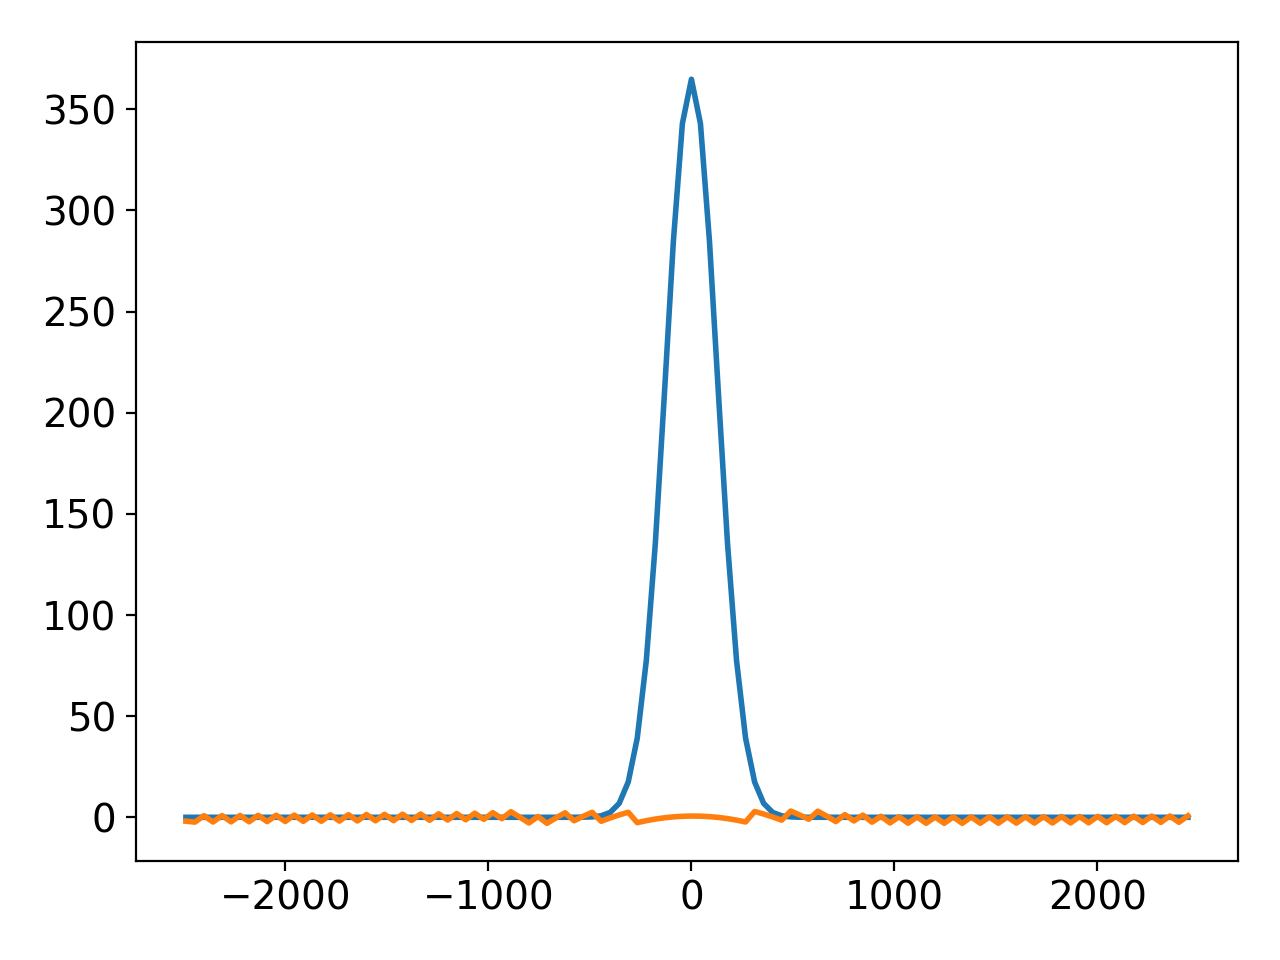

In [40]:
plt.figure()
plt.plot(pulse.t_axis,np.abs(pulse.pulse)**2)
plt.plot(pulse.t_axis,np.angle(pulse.pulse))

In [112]:
%%capture cap
# propagate pulse through beamline. This will take a minute or so (depends on number of spectral 
# components which is proportional to the ratio time_window/tau).
pulse.propagate(beamline=mono_beamline, screen_names=['im0','focus','im2'])

### Visualize output

<IPython.core.display.Javascript object>


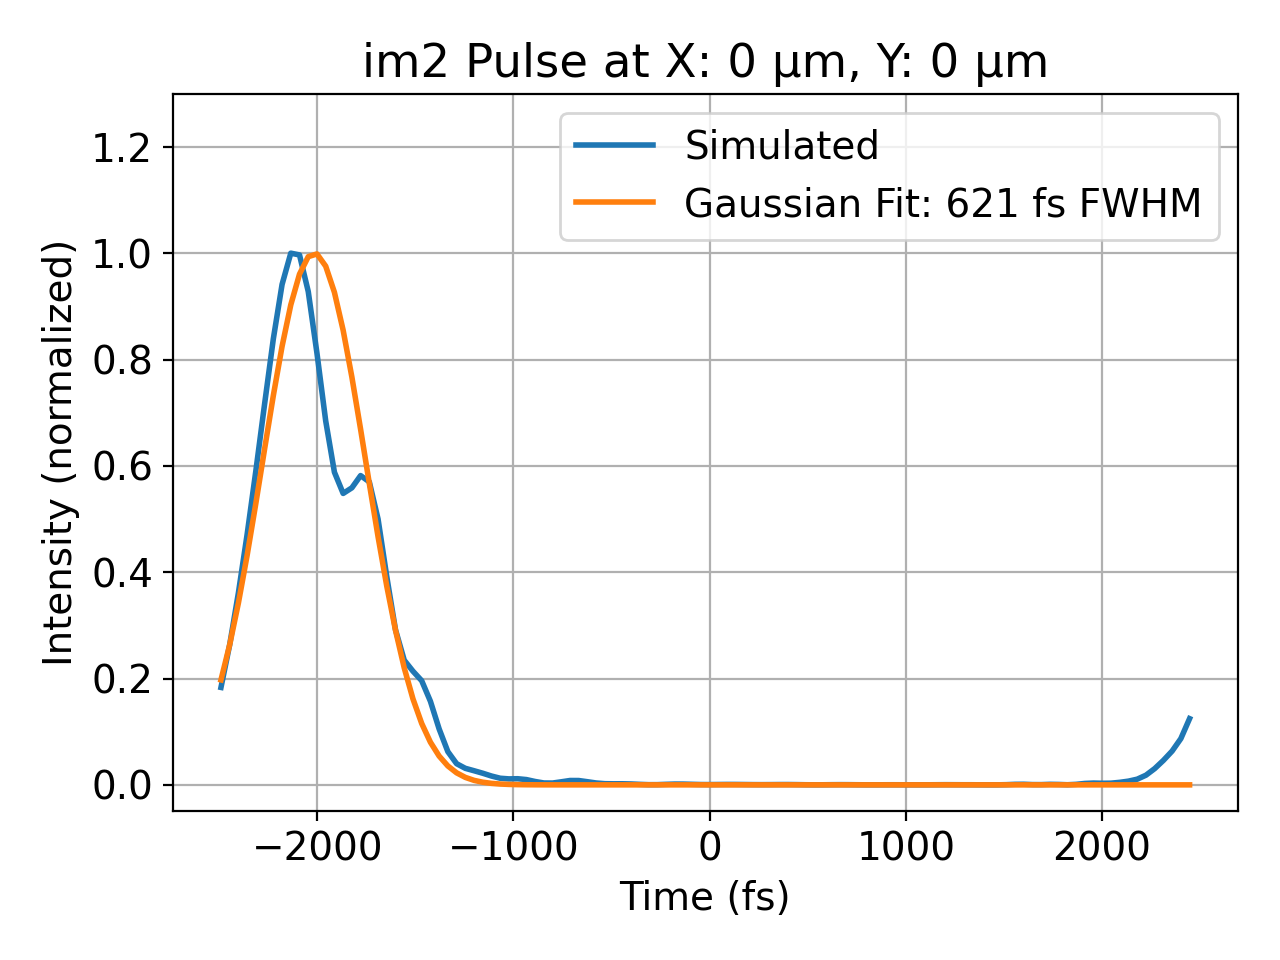

<IPython.core.display.Javascript object>


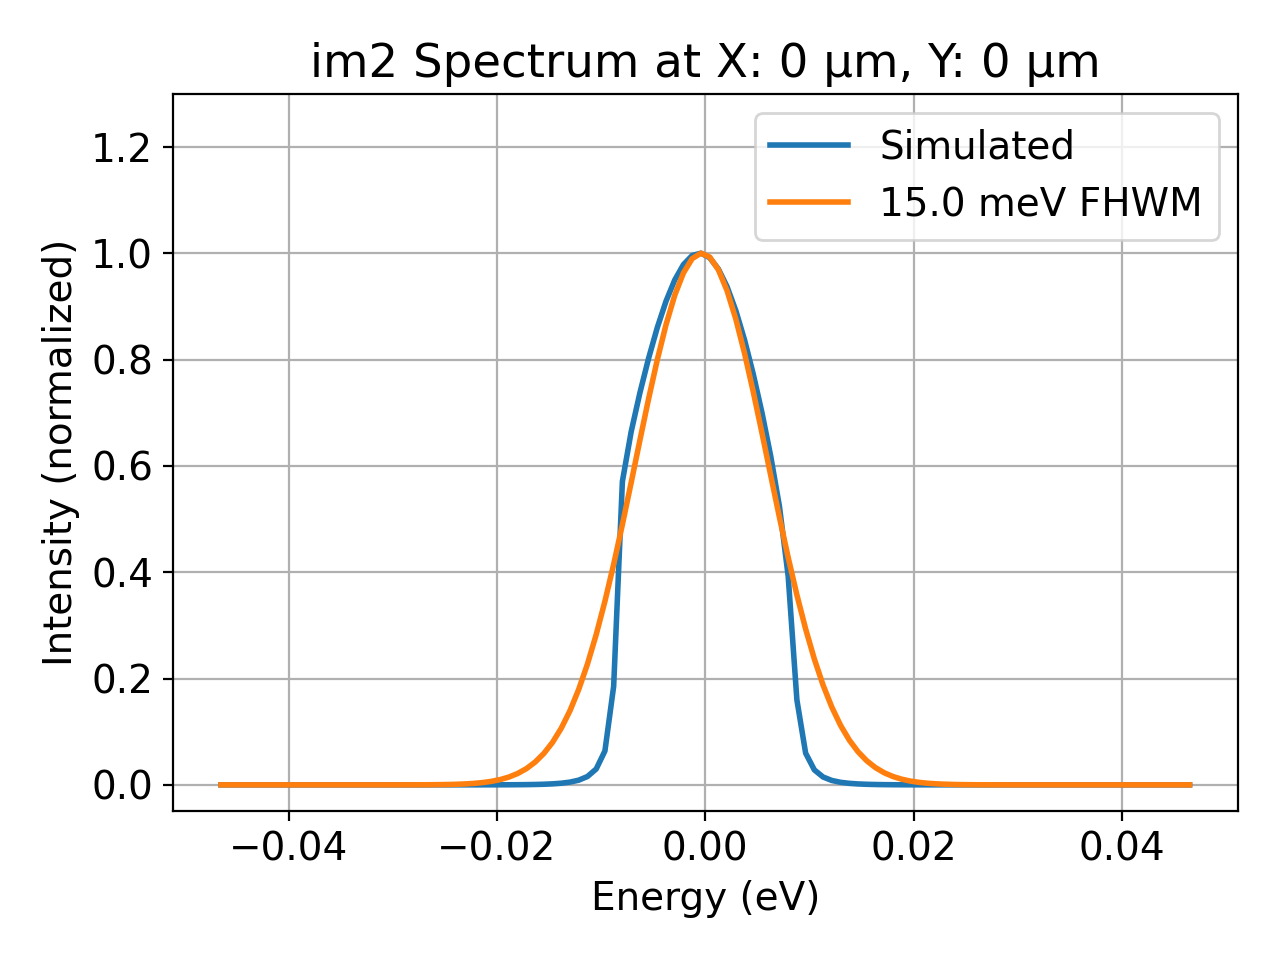

<IPython.core.display.Javascript object>


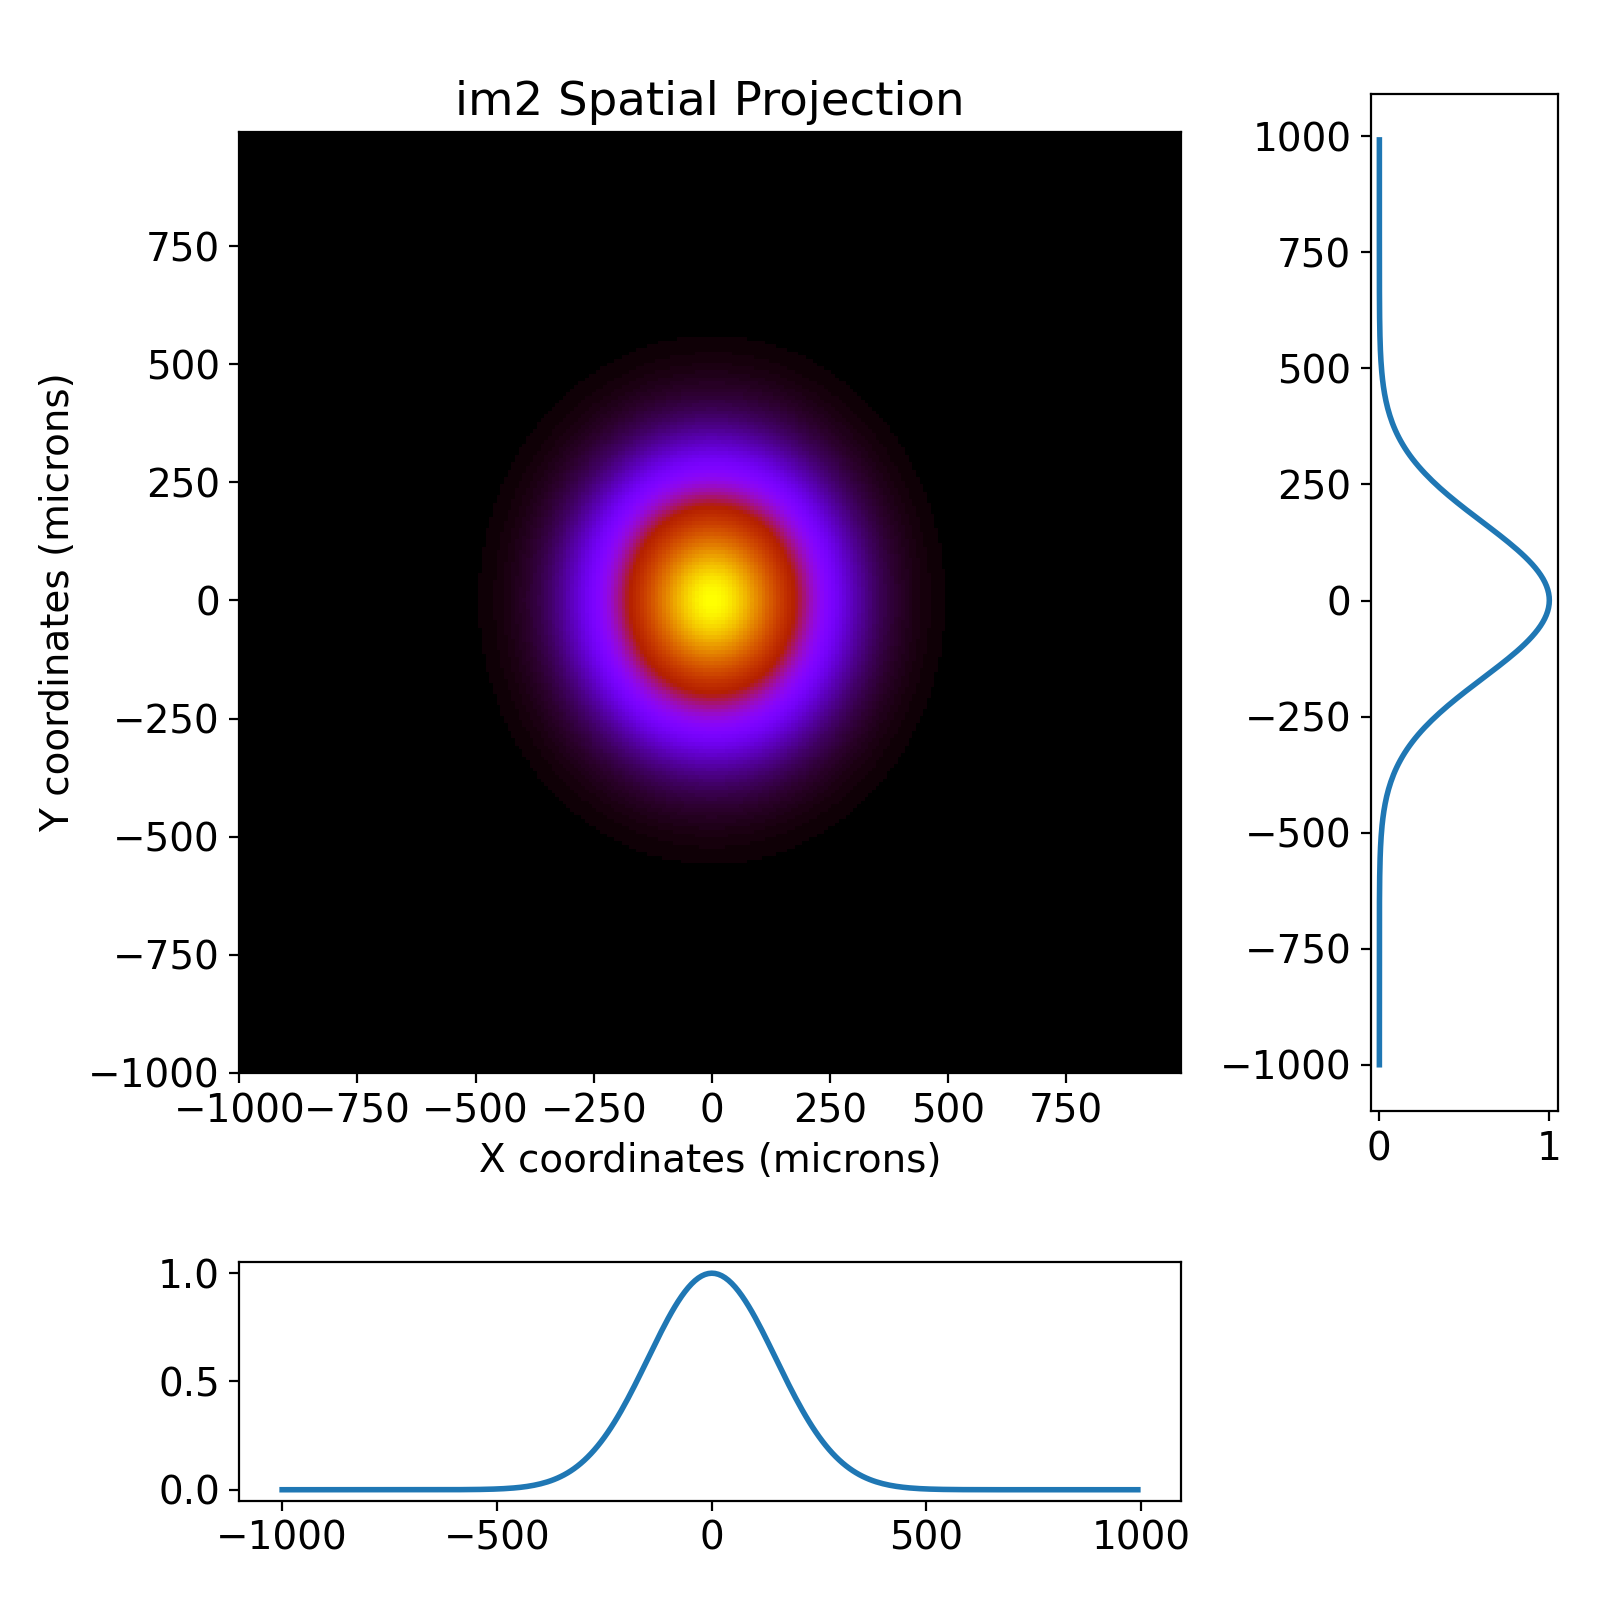

<IPython.core.display.Javascript object>


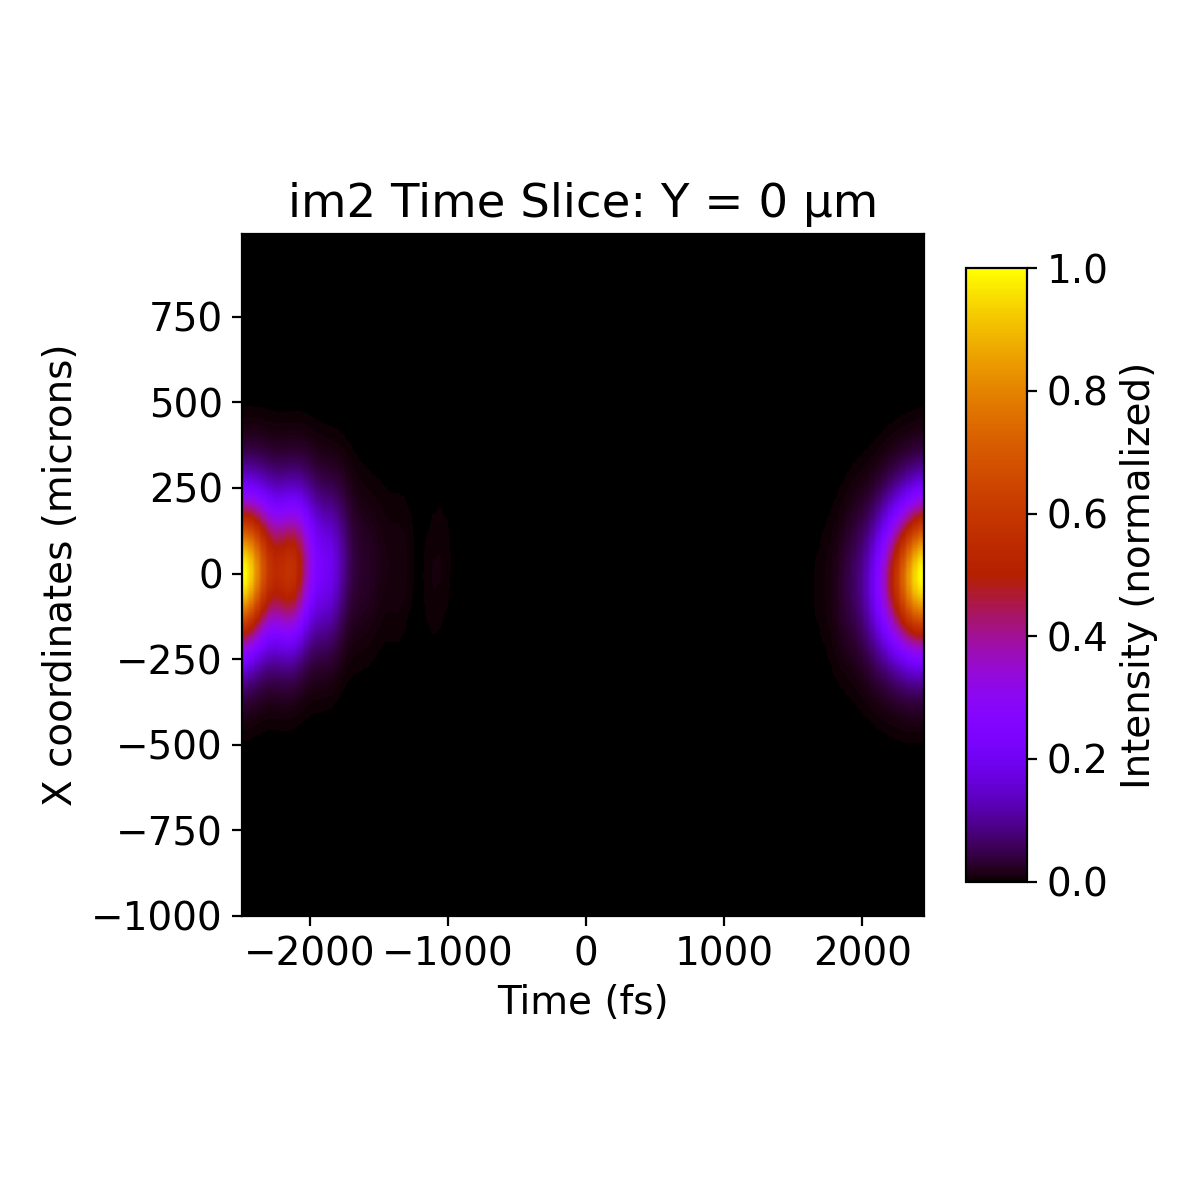

<IPython.core.display.Javascript object>


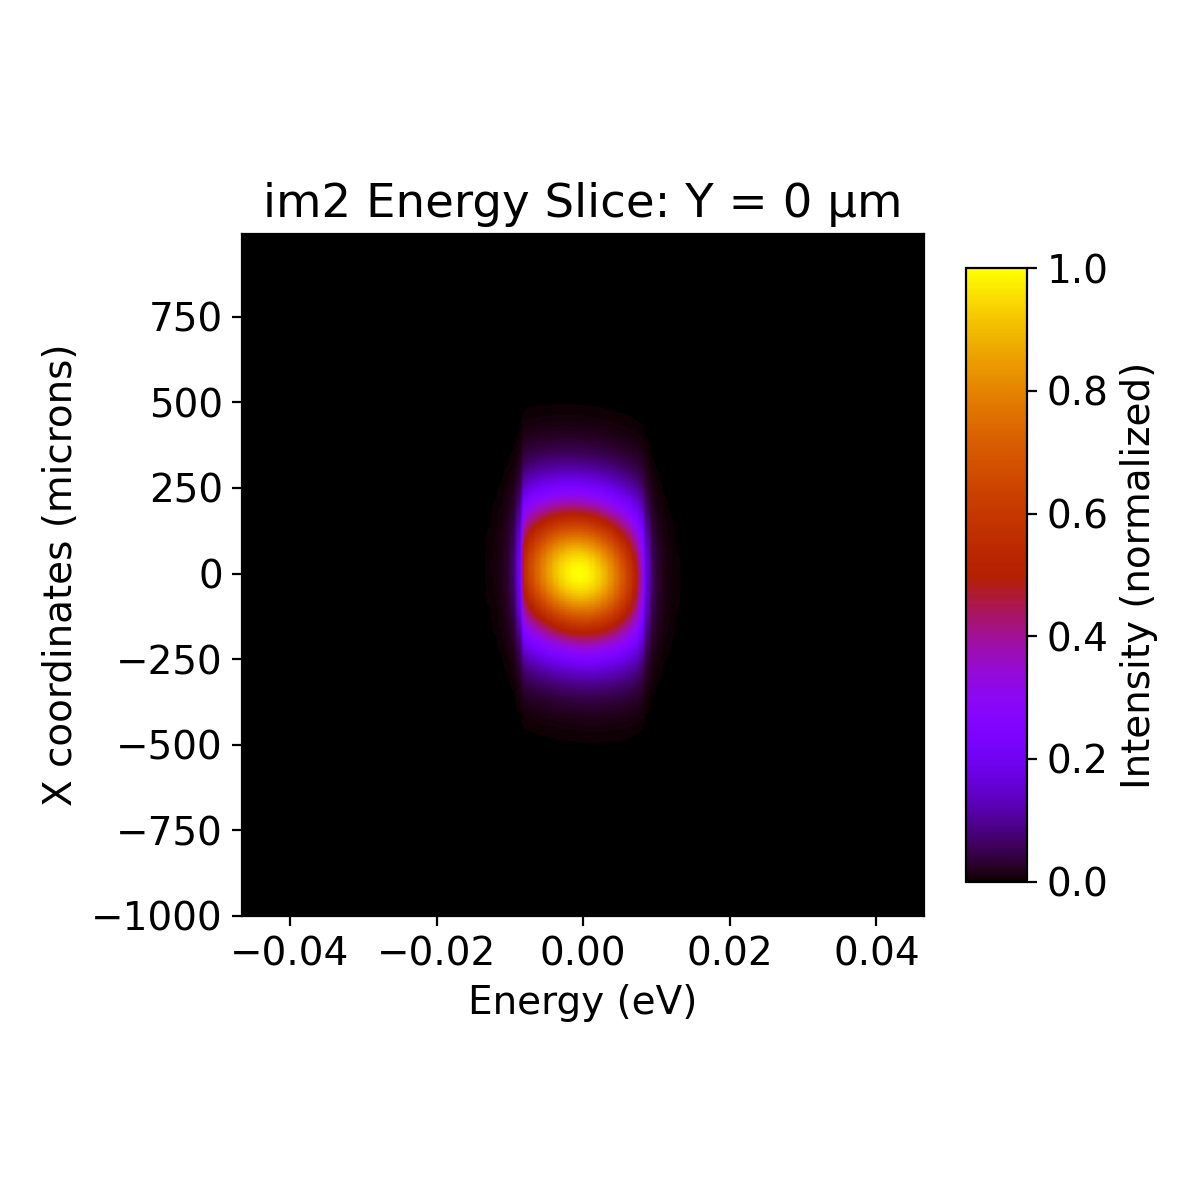

<IPython.core.display.Javascript object>


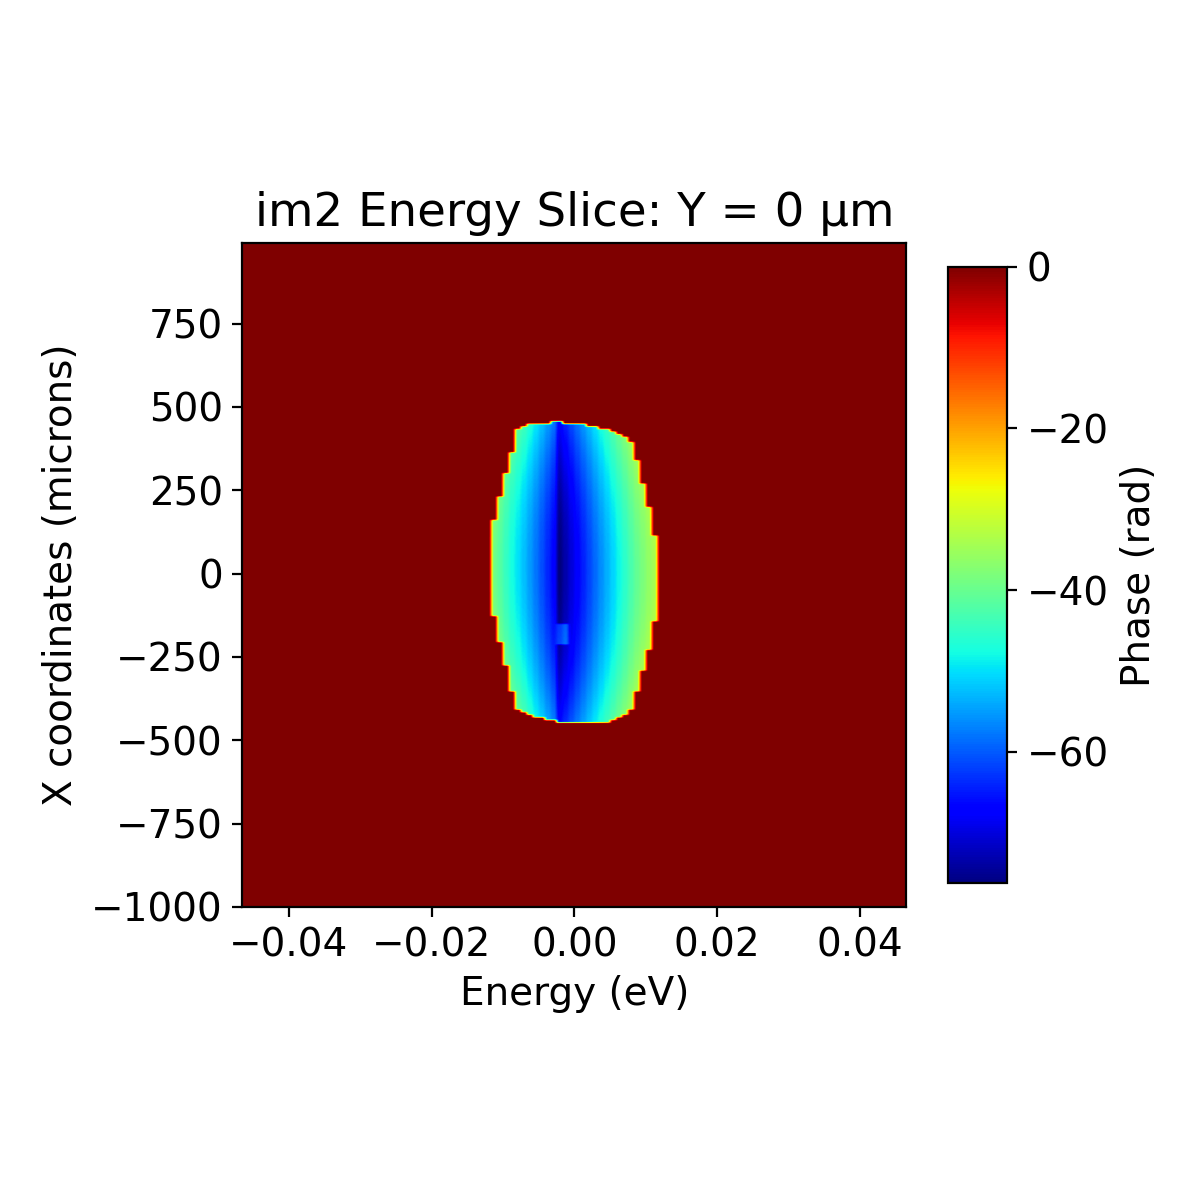

(108.28208728669969, 616)
0.18750889743704166


In [113]:
# plot output pulse at beam center
pulse.plot_pulse('im2', shift=600)
# plt.savefig(fig_path+'option1_output_pulse_no_slit.png')
# plot output spectraum at beam center
pulse.plot_spectrum('im2')
# plt.savefig(fig_path+'option1_output_spectrum_no_slit.png')
# show spatial projection of output
pulse.imshow_projection('im2')
# plt.savefig(fig_path+'option1_output_spatial_no_slit.png')
# show time slice of output
pulse.imshow_time_slice('im2', shift=200)
# plt.savefig(fig_path+'option1_output_time_no_slit.png')
# show energy slice of output
pulse.imshow_energy_slice('im2')
# plt.savefig(fig_path+'option1_output_energy_no_slit.png')
# show spectral phase slice of output
pulse.imshow_energy_slice('im2', image_type='phase')
print(pulse.pulse_duration('im2'))
# f1 = np.linspace(2.88, 2.887, 50)
# print(f1)
print(pulse.pulsefront_tilt('im2'))

In [60]:
print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

crystal 2 incidence angle: 60.96 degrees
crystal 2 exit angle: 5.01 degrees


### Propagation through monochromator at central photon energy

In [7]:
print(crl1.roc)

2.1437791431002858e-05


FWHM in x: 281.2056638883335 microns
FWHM in y: 281.2056638883335 microns
FWHM Divergence (x): 1.1 μrad
FWHM Divergence (y): 1.1 μrad
23.85355098222798
23.85355098222798
x is focused
y is focused
im0
zx: 246.000000
zy: 246.000000
azimuth 0.00 mrad
drift1
global_x 0.00
global_y 0.00
x intersect: 0.0000e+00
component x: 0.0000e+00
y intersect: 0.0000e+00
component y: 0.0000e+00
delta z: 0.00
zRx: 342624978.20 microns
zRy: 342624978.20 microns
remaining distance: 60000000.00 microns
goal for zx: 306000000.00 microns
current zx: 246000000.00 microns
goal for zy: 306000000.00 microns
current zy: 246000000.00 microns
zx: 306.000000
zy: 306.000000
azimuth 0.00 mrad
crl0
zRx: 2.53e+07
zRy: 2.71e+02
y becomes unfocused
focal length: 305.00
zx: -93480.640359
zy: 306.000000
azimuth 0.00 mrad
drift2
global_x 0.00
global_y 0.00
x intersect: 0.0000e+00
component x: 0.0000e+00
y intersect: 0.0000e+00
component y: 0.0000e+00
delta z: 0.00
zRx: 25292062680546.25 microns
zRy: 271009019.50 microns
remain

/Users/seaberg/beamline/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


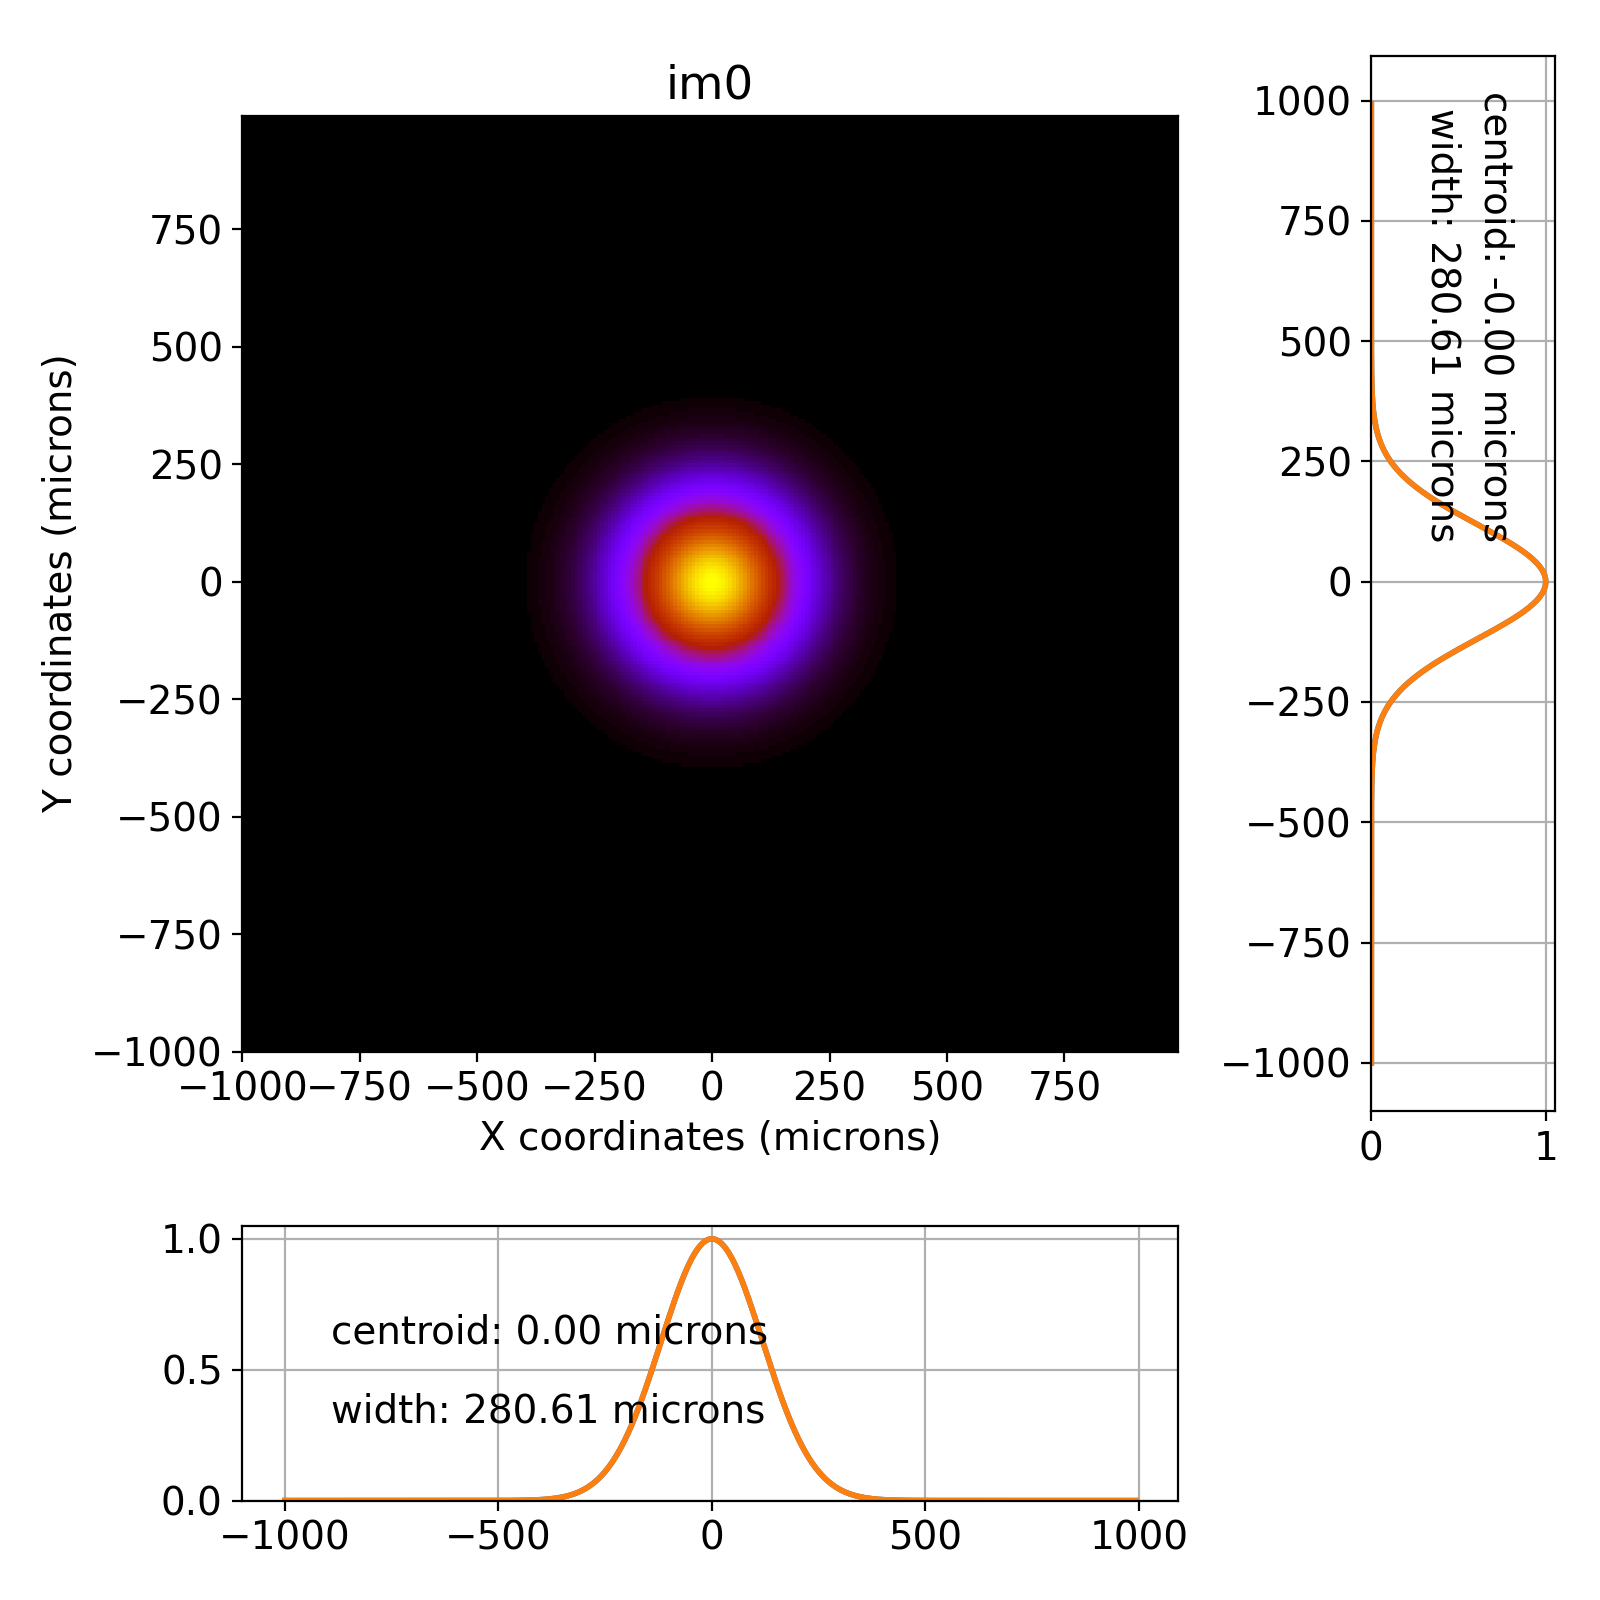

<IPython.core.display.Javascript object>


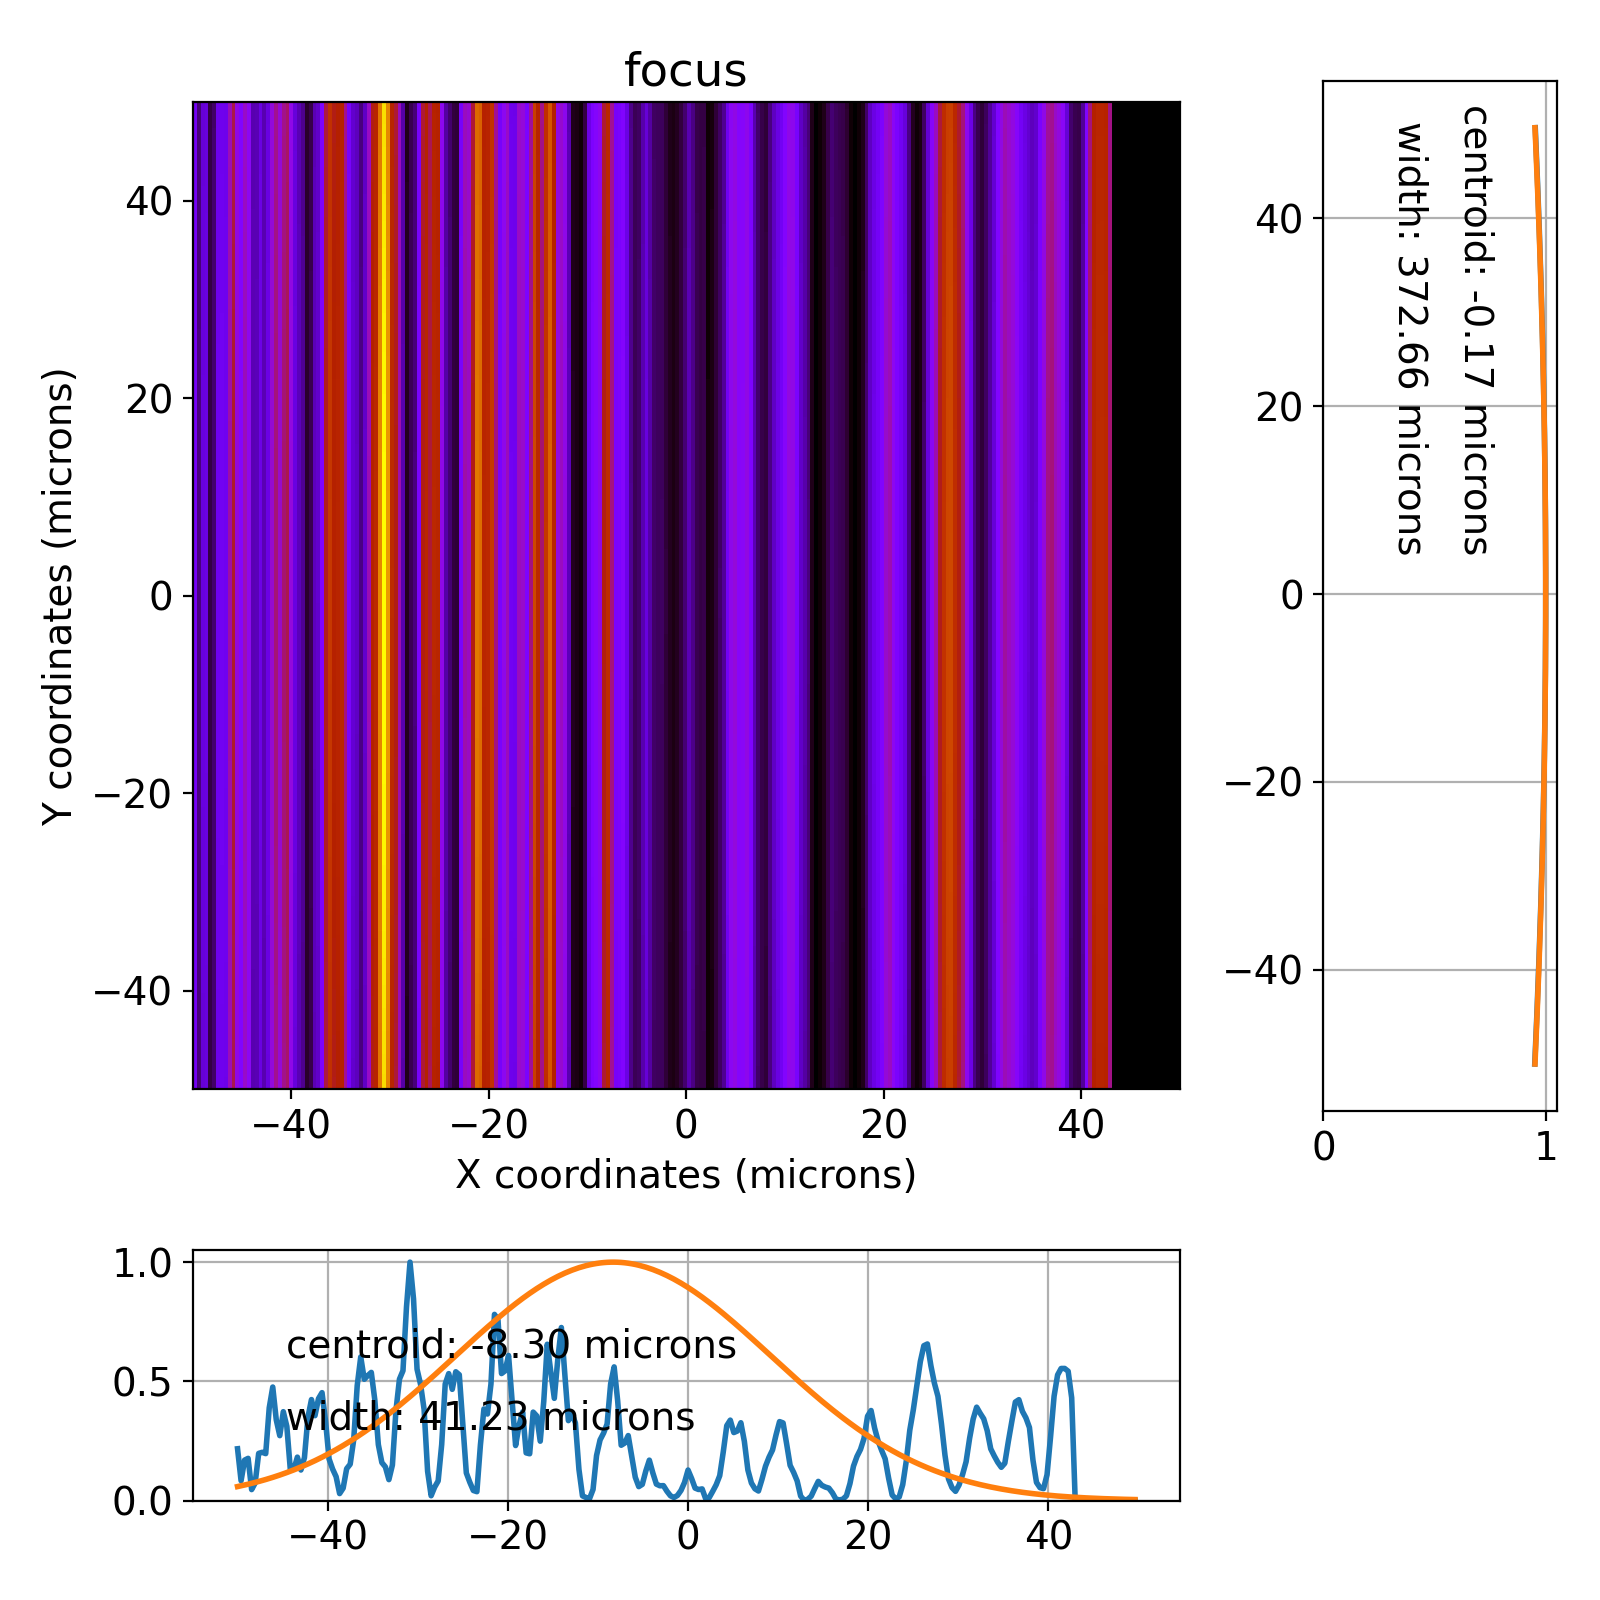

<IPython.core.display.Javascript object>


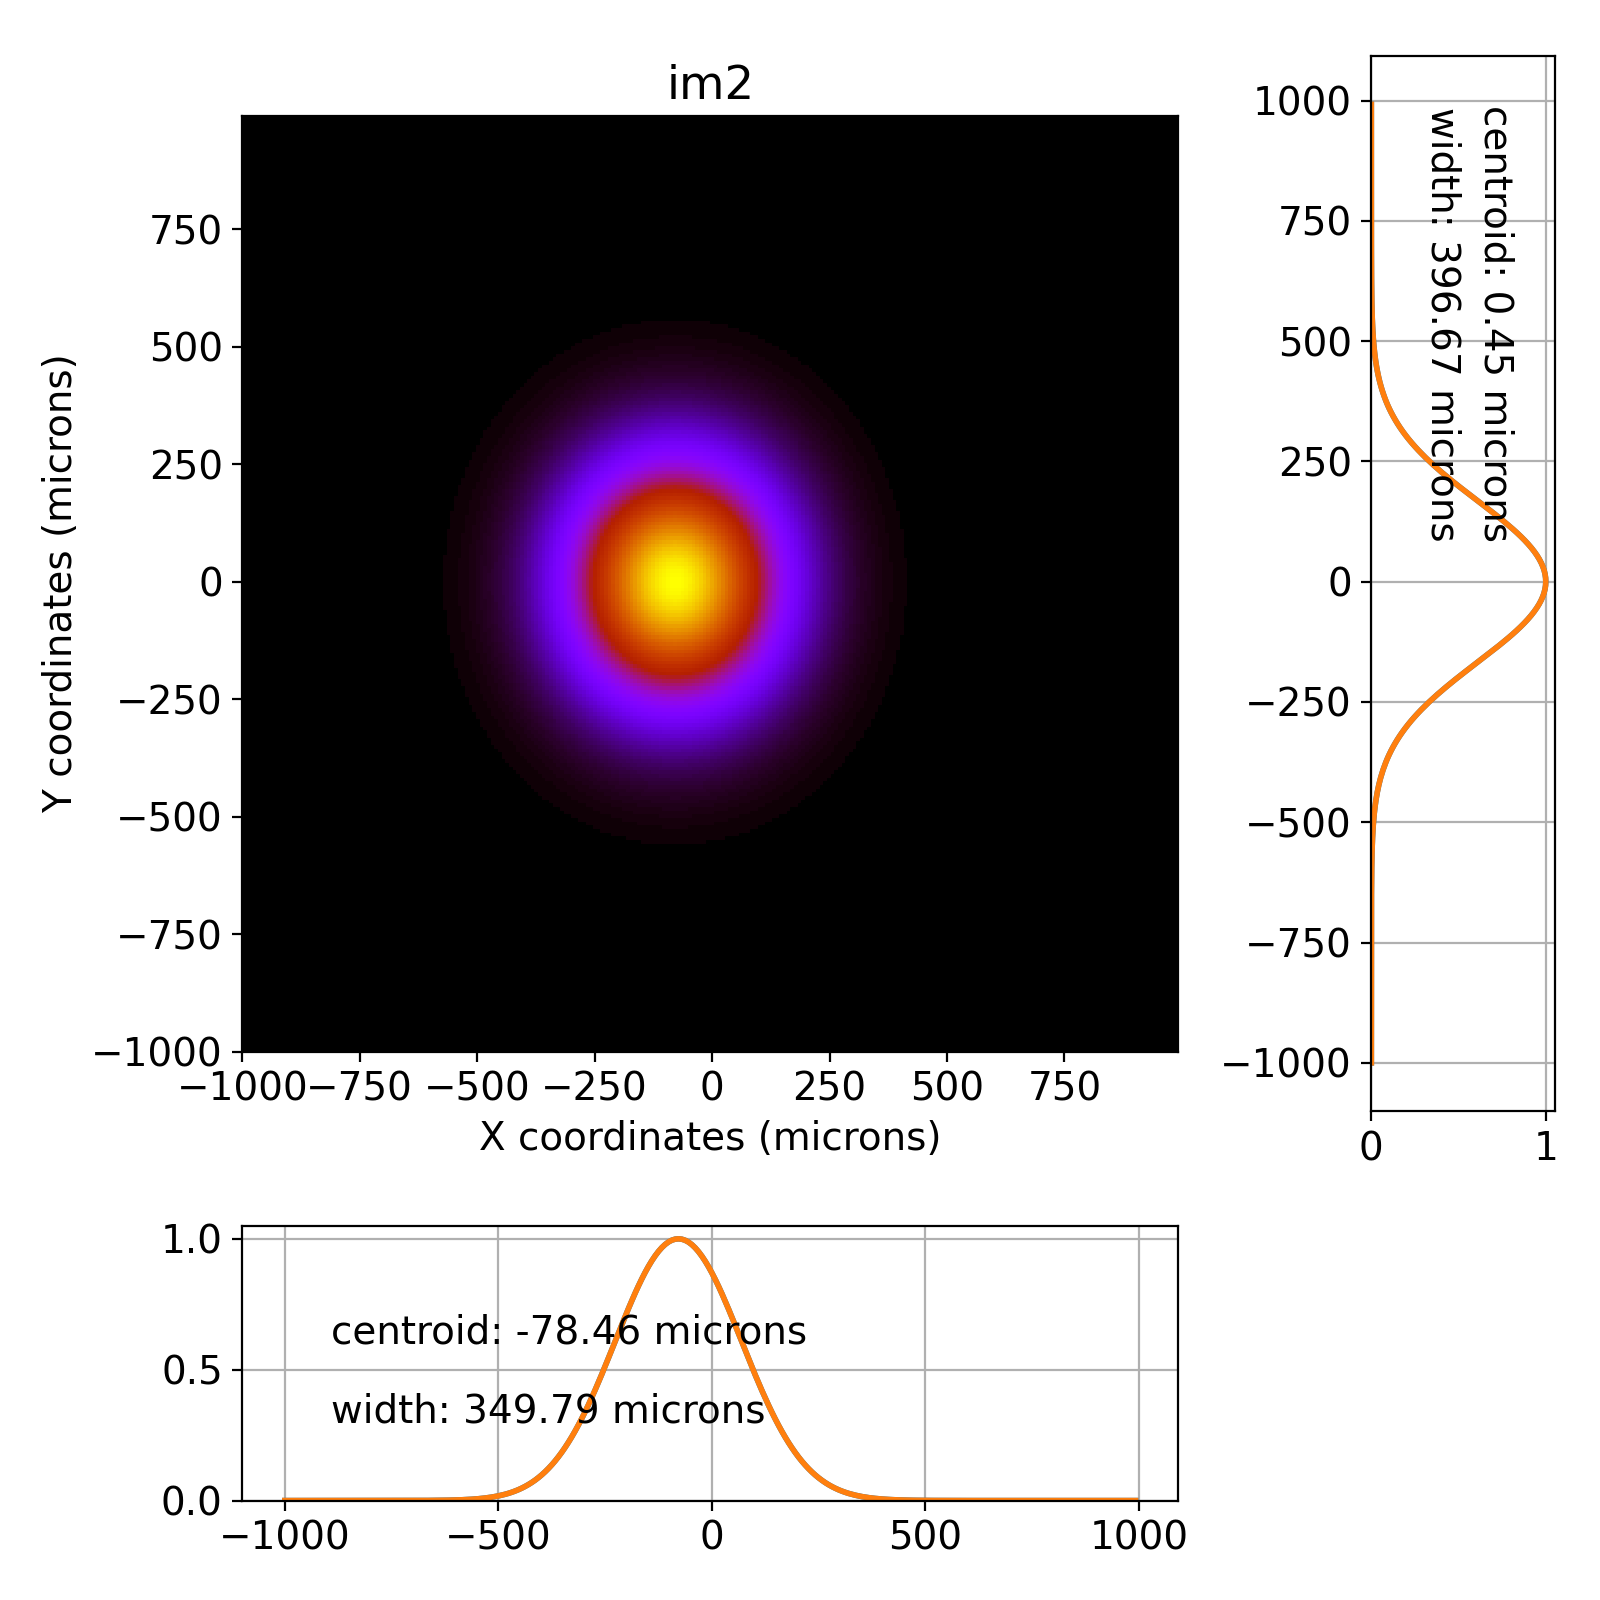

In [114]:
# propagate
b2 = mono_beamline.propagate_beamline(b1)

# view beam at various locations
mono_beamline.im0.view_beam()
# mono_beamline.imcrl.view_beam()
# mono_beamline.imc3.view_beam()
mono_beamline.focus.view_beam()
mono_beamline.im2.view_beam()

## Time-domain propagation

In [6]:
# reset central photon energy
beam_params['photonEnergy'] = 17795

# initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
pulse = beam.Pulse(beam_params=beam_params, tau=20, time_window=5000)

print('Number of spectral components: {:d}'.format(pulse.N))

Number of spectral components: 562


In [7]:
%%capture capt
# propagate pulse through beamline. This will take a minute or so (depends on number of spectral 
# components which is proportional to the ratio time_window/tau).
pulse.propagate(beamline=mono_beamline, screen_names=['im0','focus','im2'])
# pulse.propagate(beamline=mono_beamline, screen_names=['imcrl','imc3'])

<IPython.core.display.Javascript object>


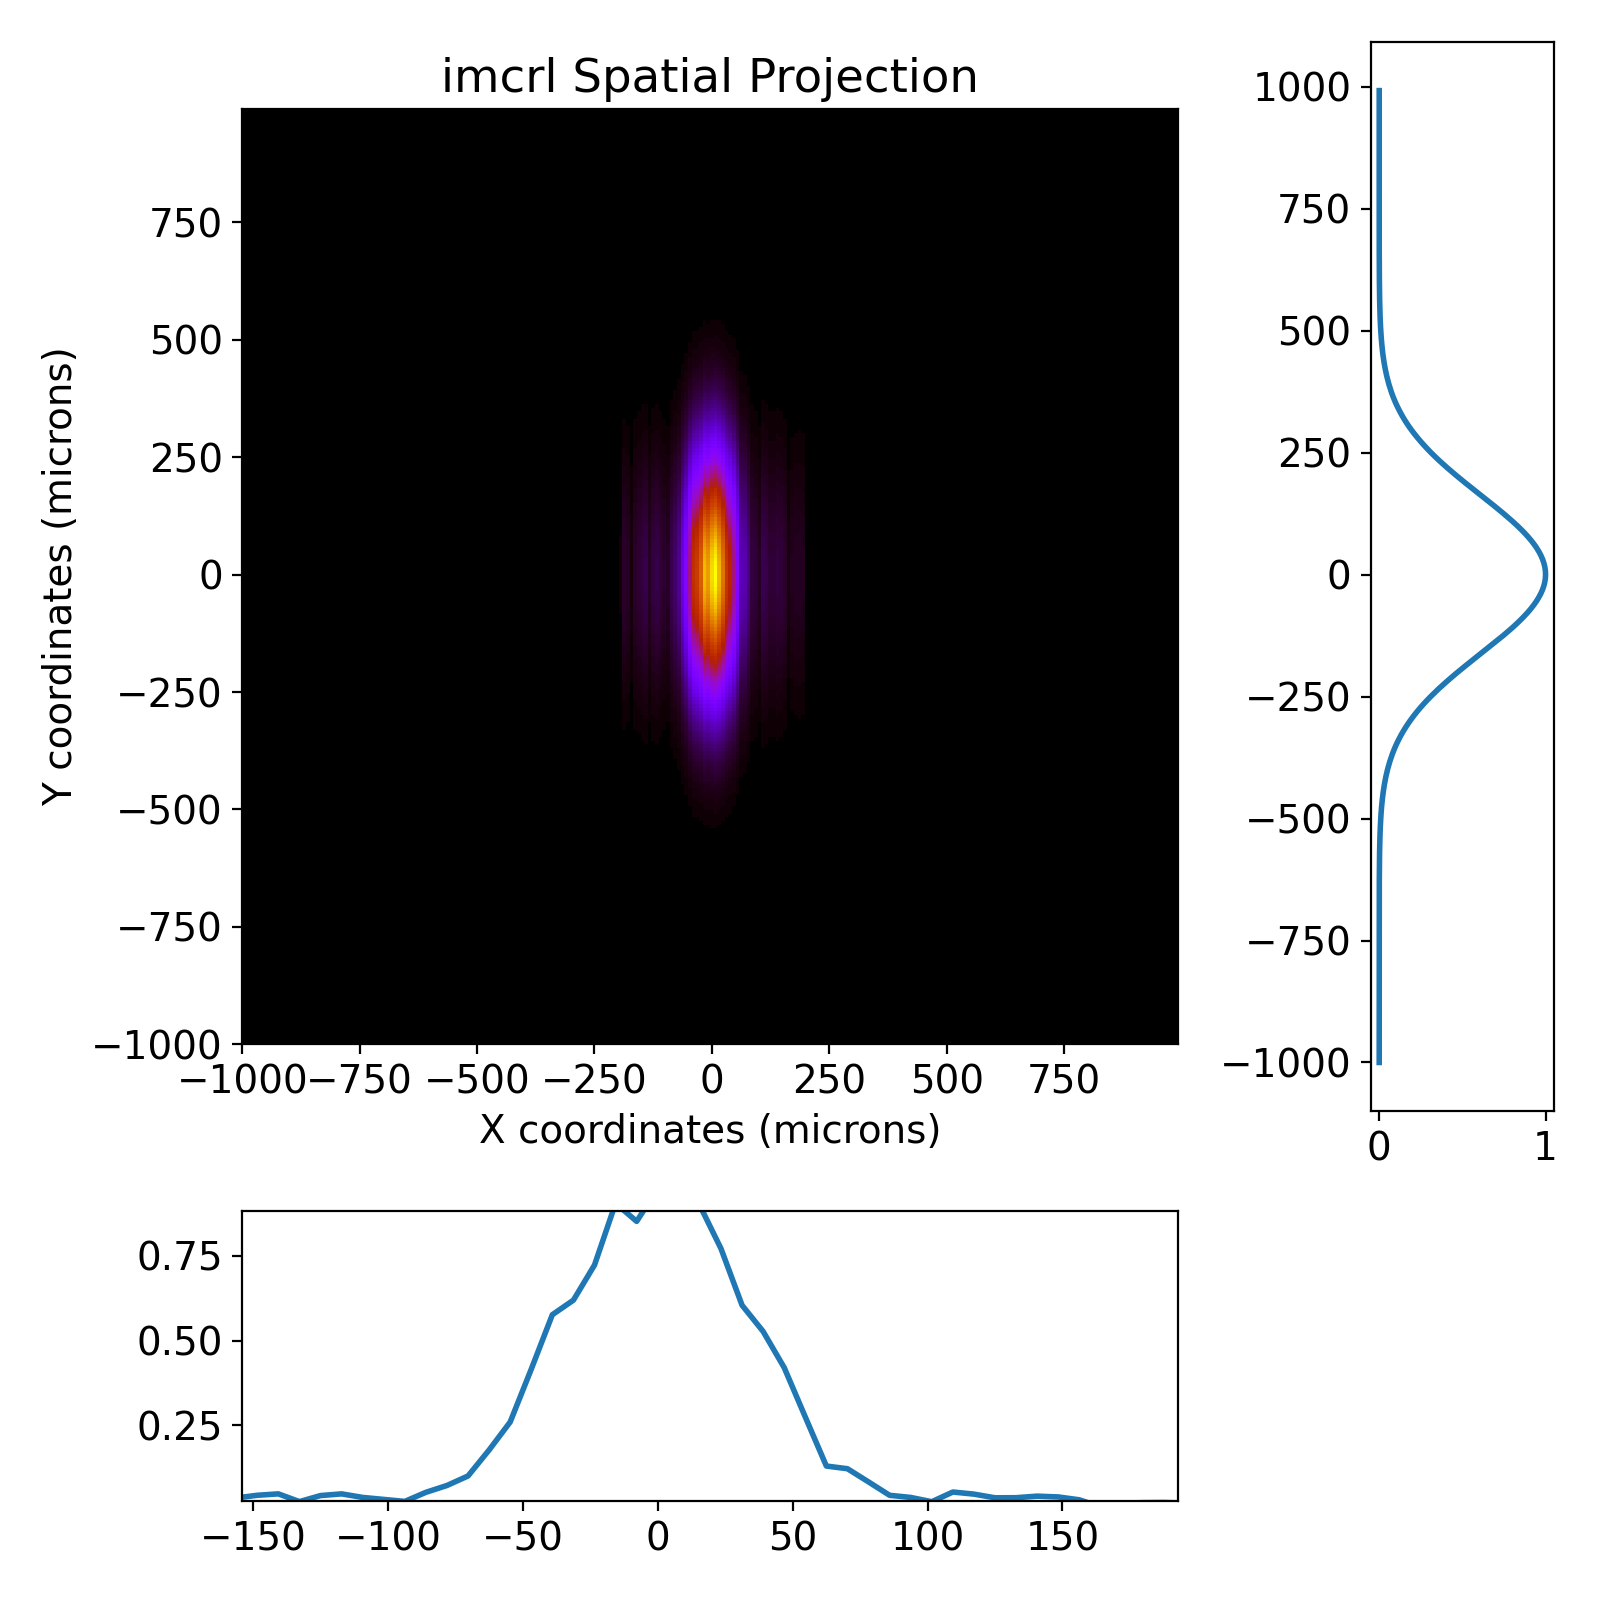

<IPython.core.display.Javascript object>


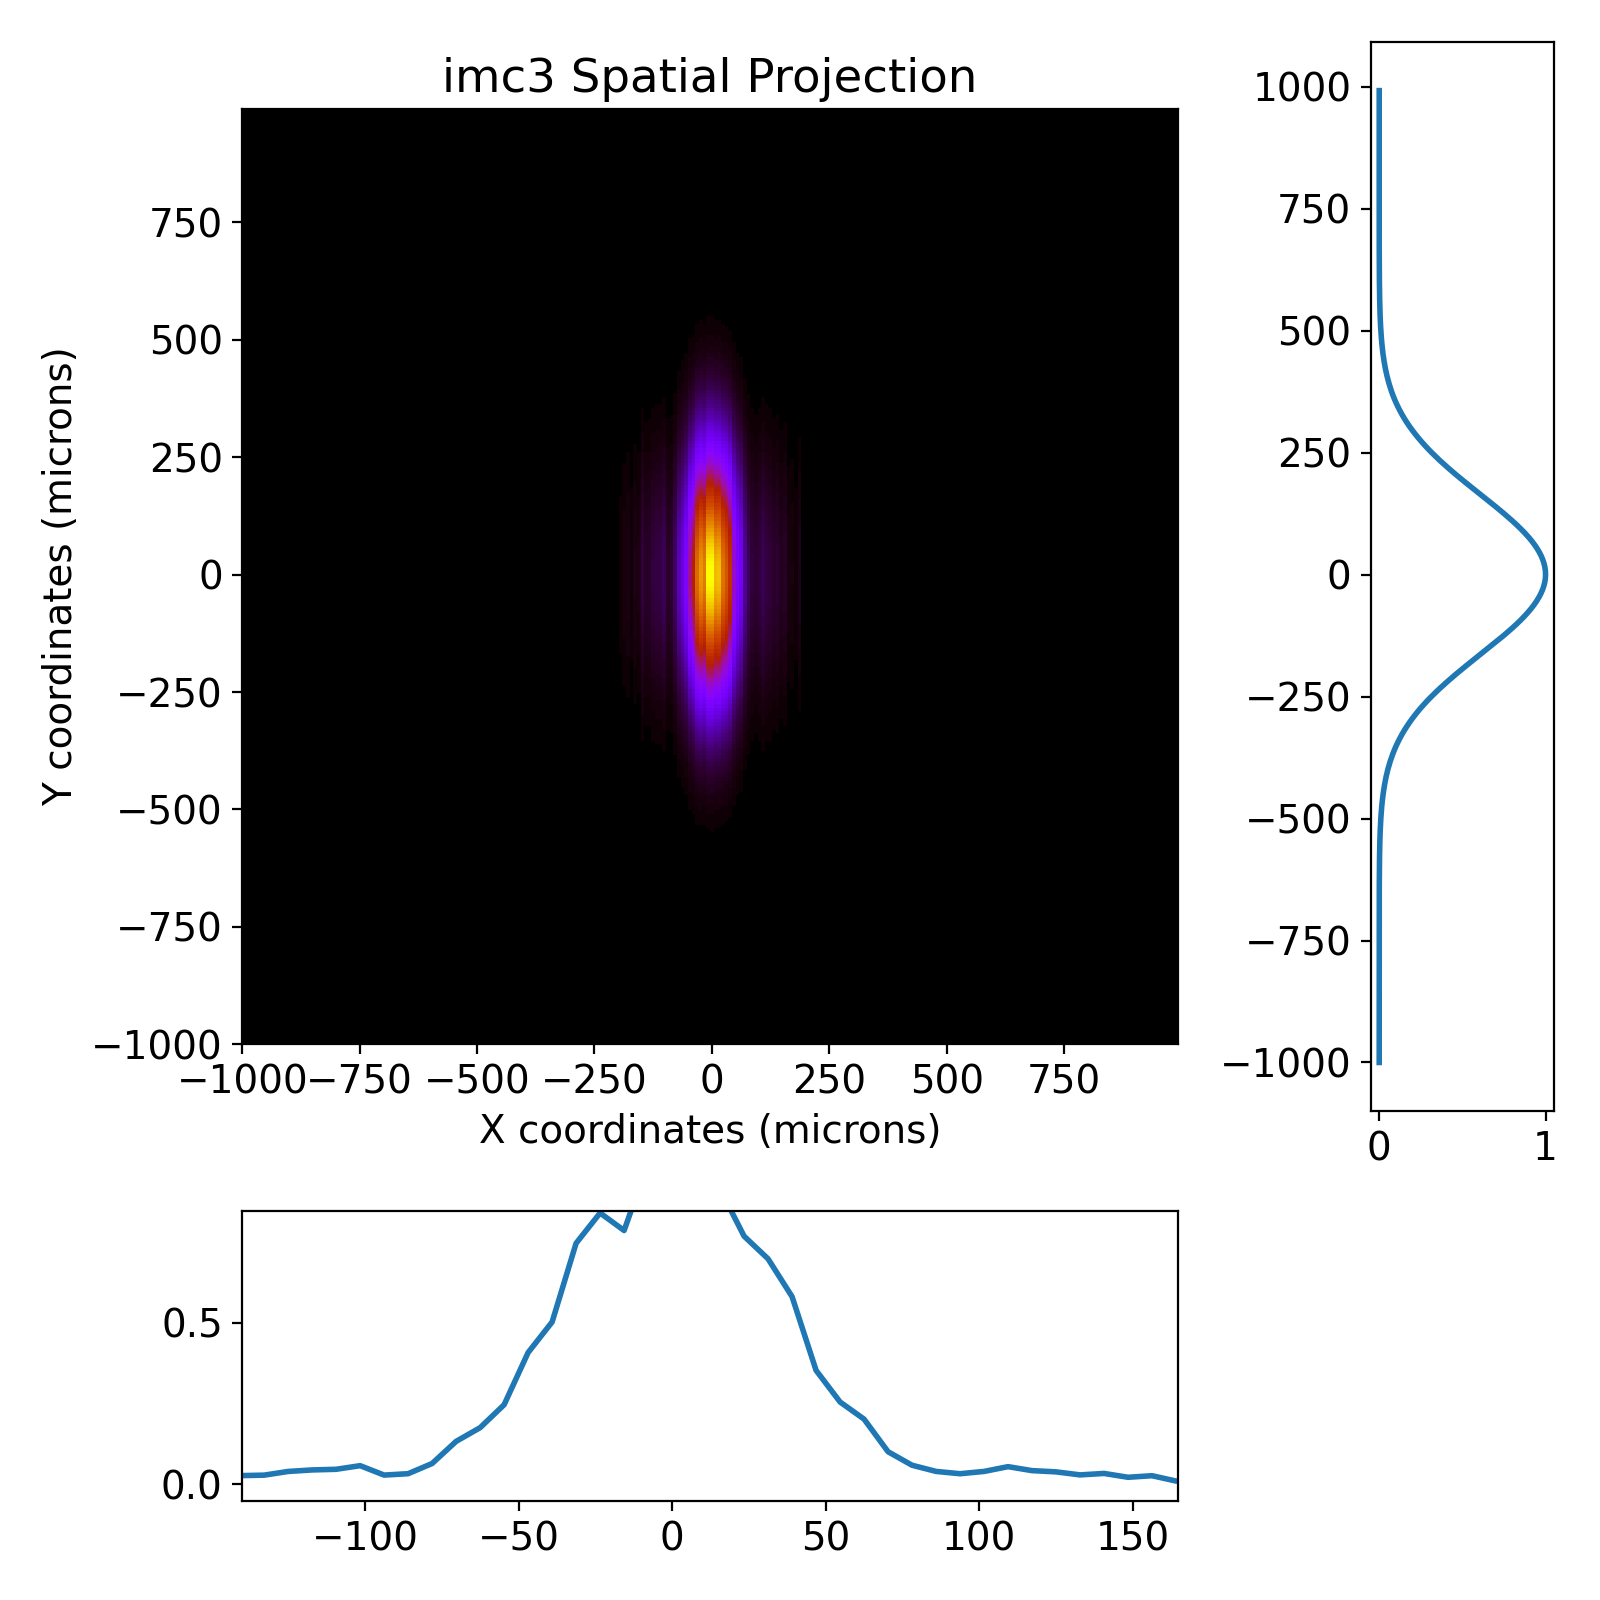

(<matplotlib.axes._subplots.AxesSubplot at 0x124af4fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1235e6978>)

In [188]:
pulse.imshow_projection('imcrl')
pulse.imshow_projection('imc3')

### Visualize input

<IPython.core.display.Javascript object>


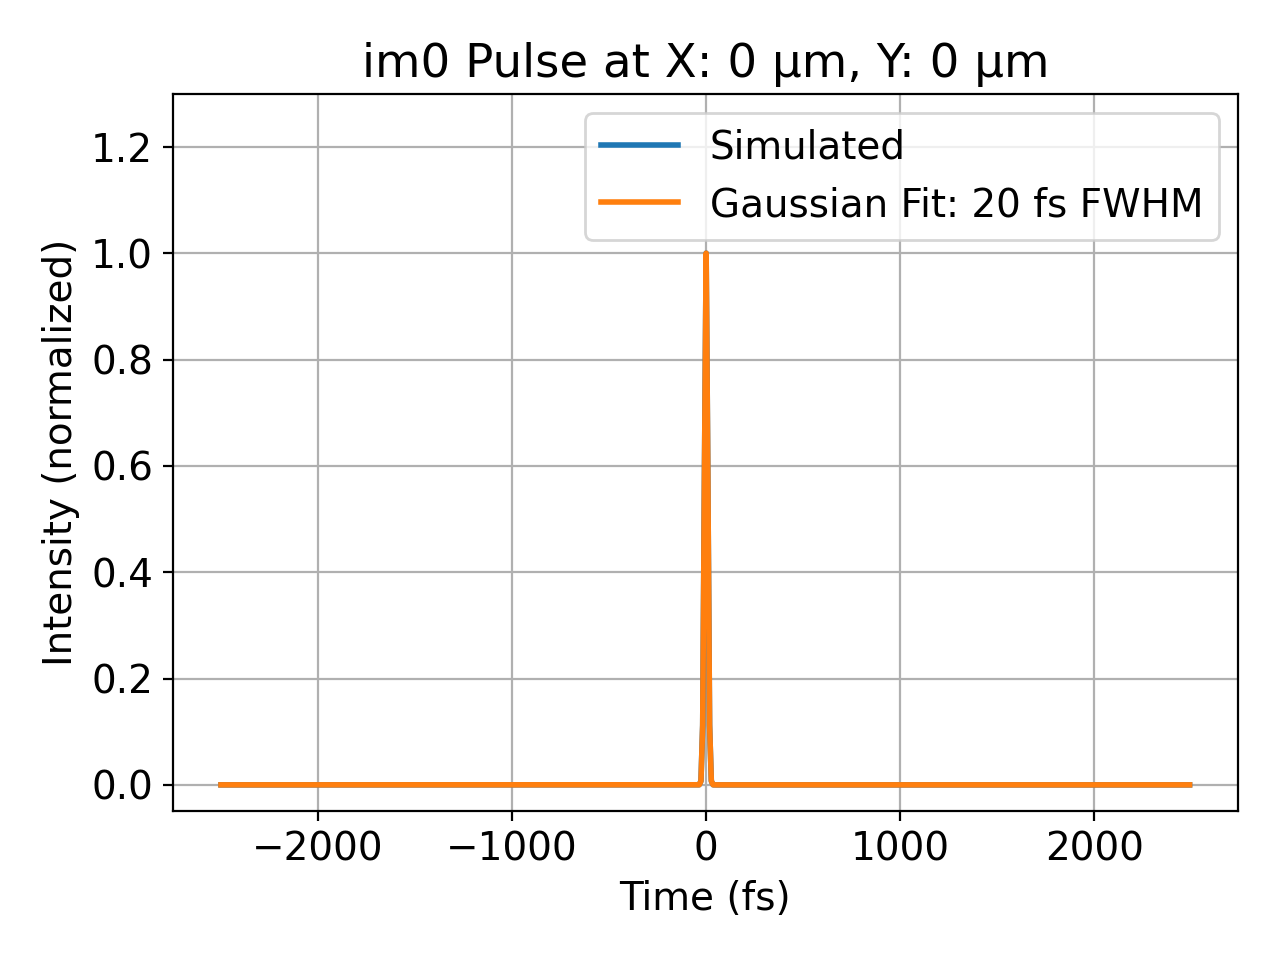

<IPython.core.display.Javascript object>


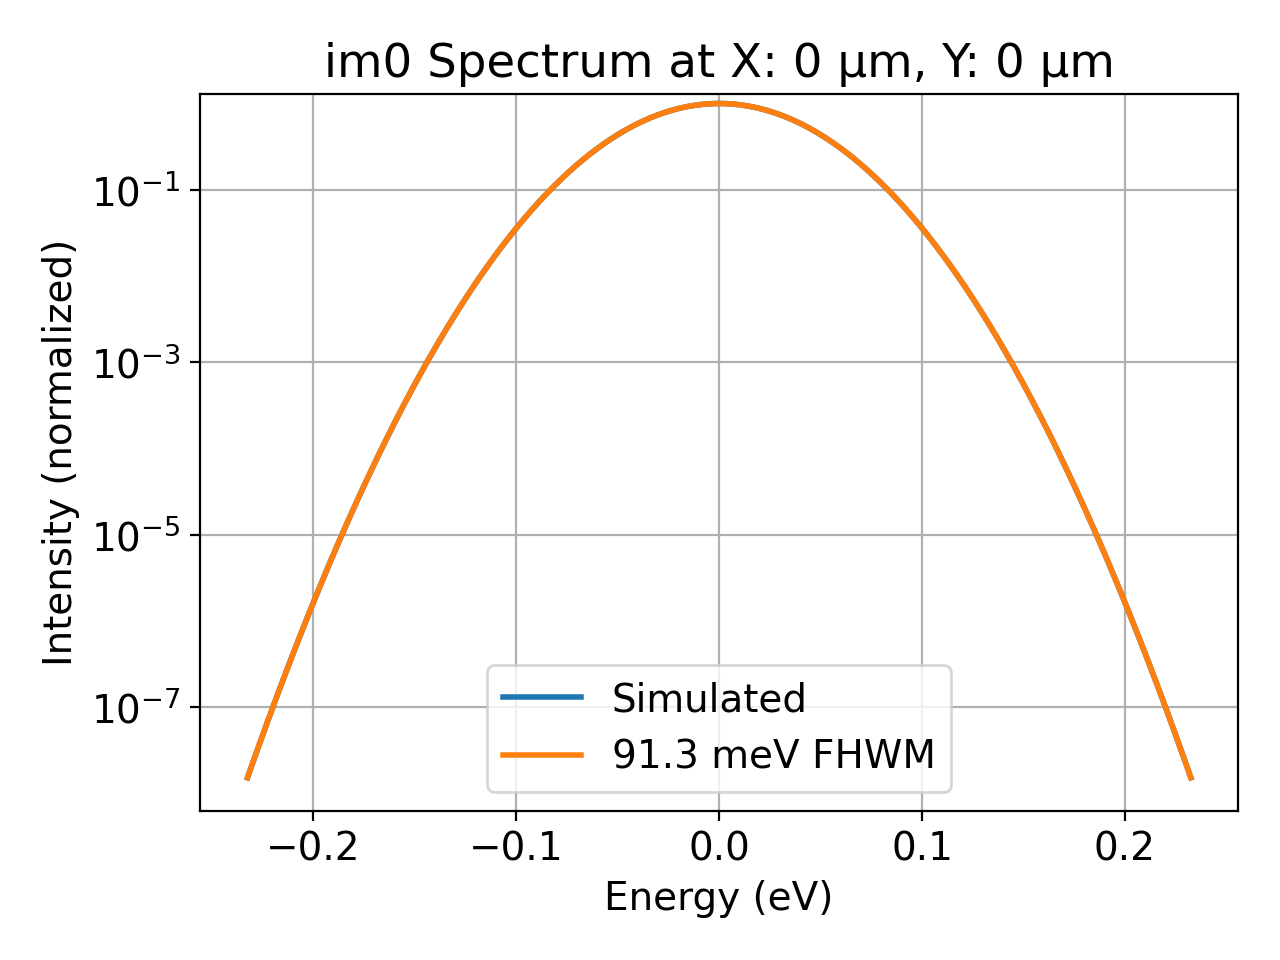

/Users/seaberg/Python/lcls_beamline_toolbox/lcls_beamline_toolbox/xraybeamline2d/beam1d.py:1464: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-.05,1.3)


<IPython.core.display.Javascript object>


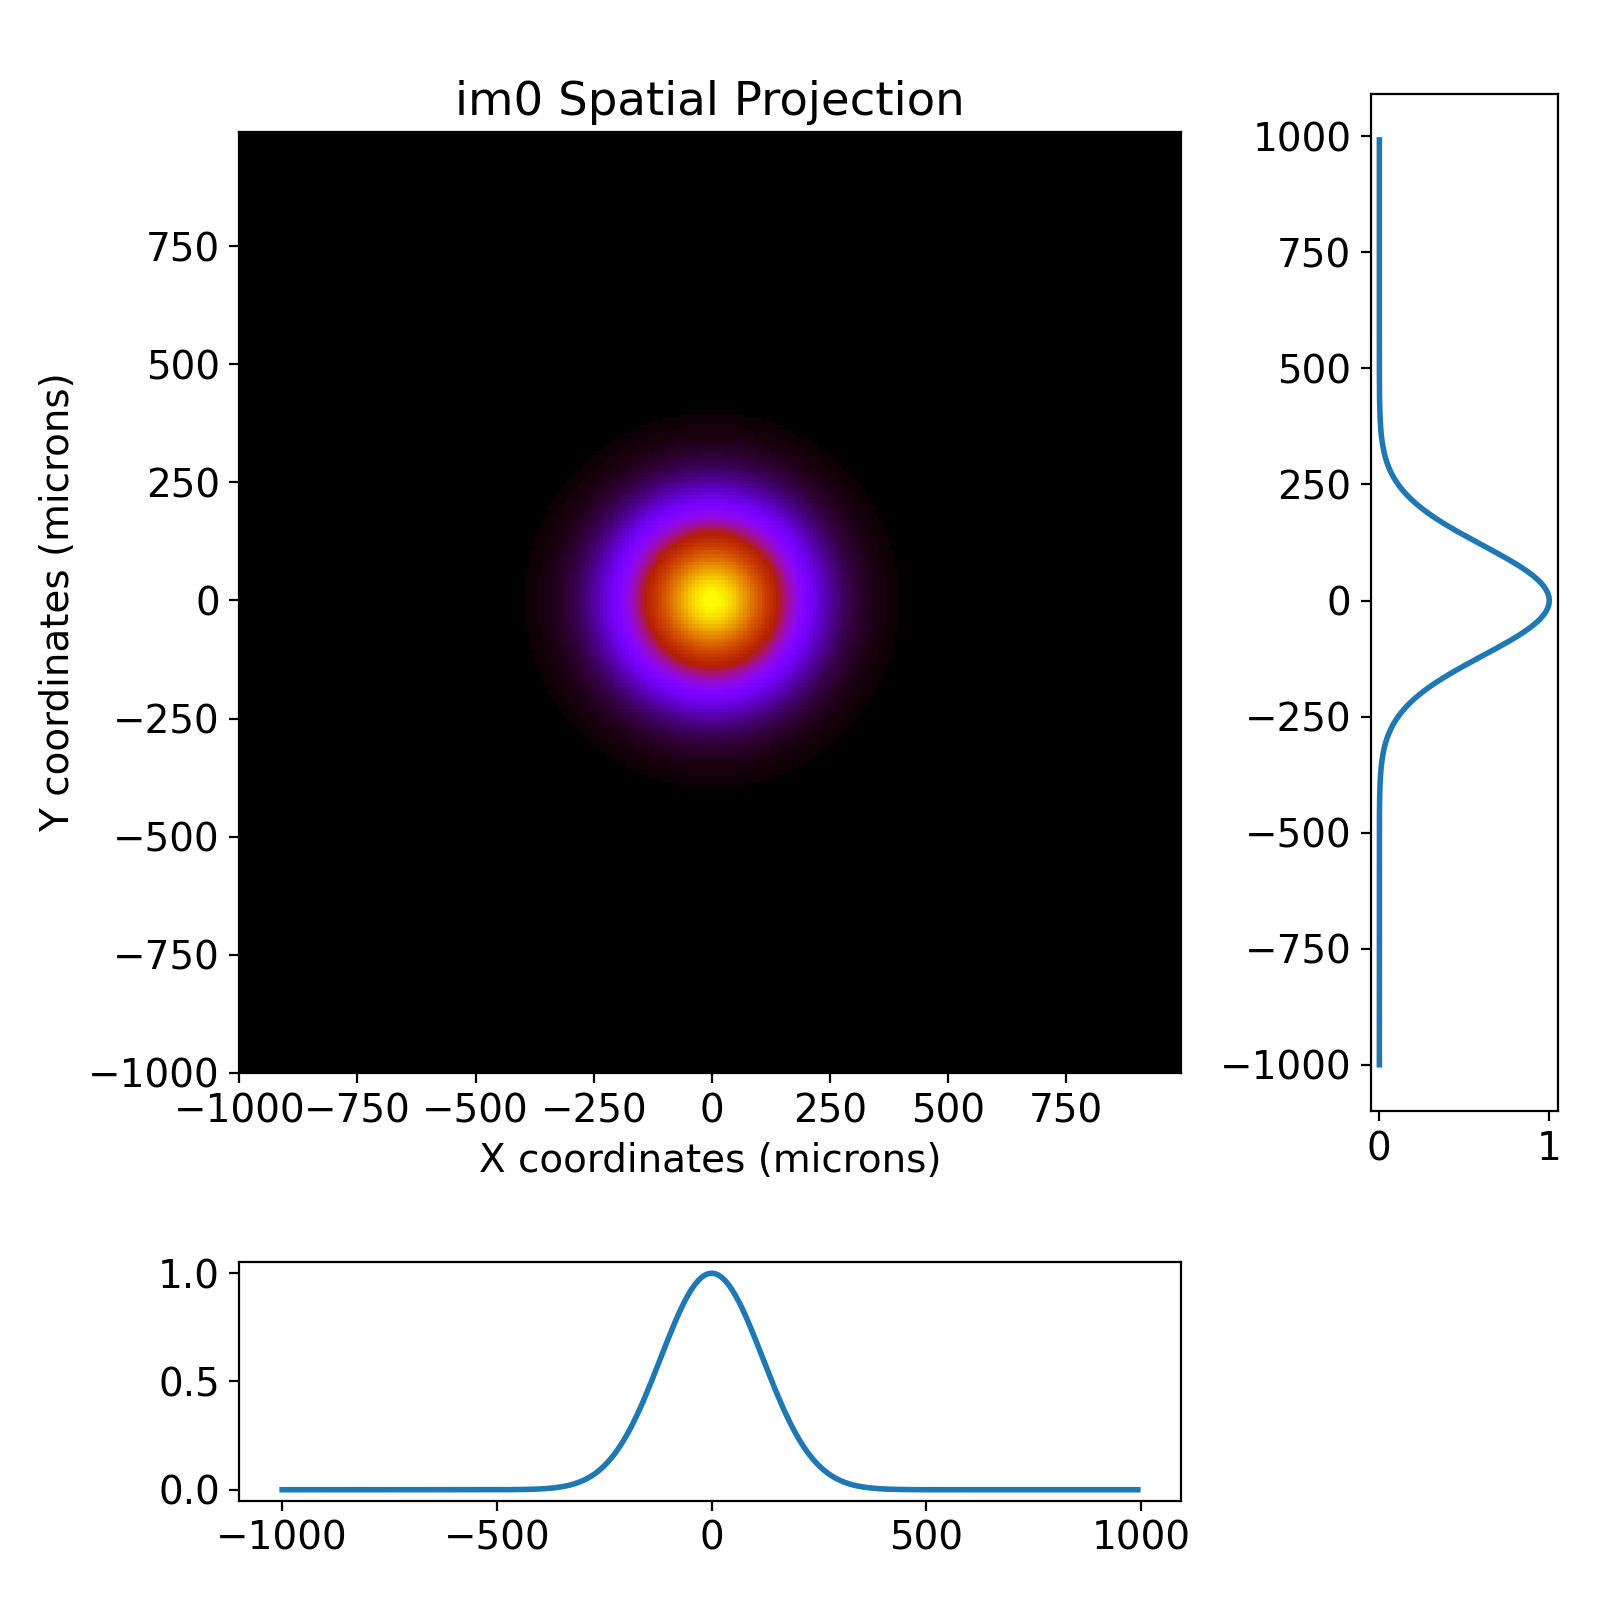

(<matplotlib.axes._subplots.AxesSubplot at 0x120c45c88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120ccad68>)

In [8]:
fig_path = '/Users/Matt/OneDrive - SLAC National Accelerator Laboratory/Projects/Tunable Mono/figures/'

# plot input pulse at beam center
pulse.plot_pulse('im0')
# plt.savefig(fig_path+'input_pulse_slit.png')
# plot input spectrum at beam center
pulse.plot_spectrum('im0', log=True)
# plt.savefig(fig_path+'input_spectrum_slit.png')
# plot input beam spatial projection
pulse.imshow_projection('im0')
# plt.savefig(fig_path+'input_spatial_slit.png')

### Visualize focus properties

<IPython.core.display.Javascript object>


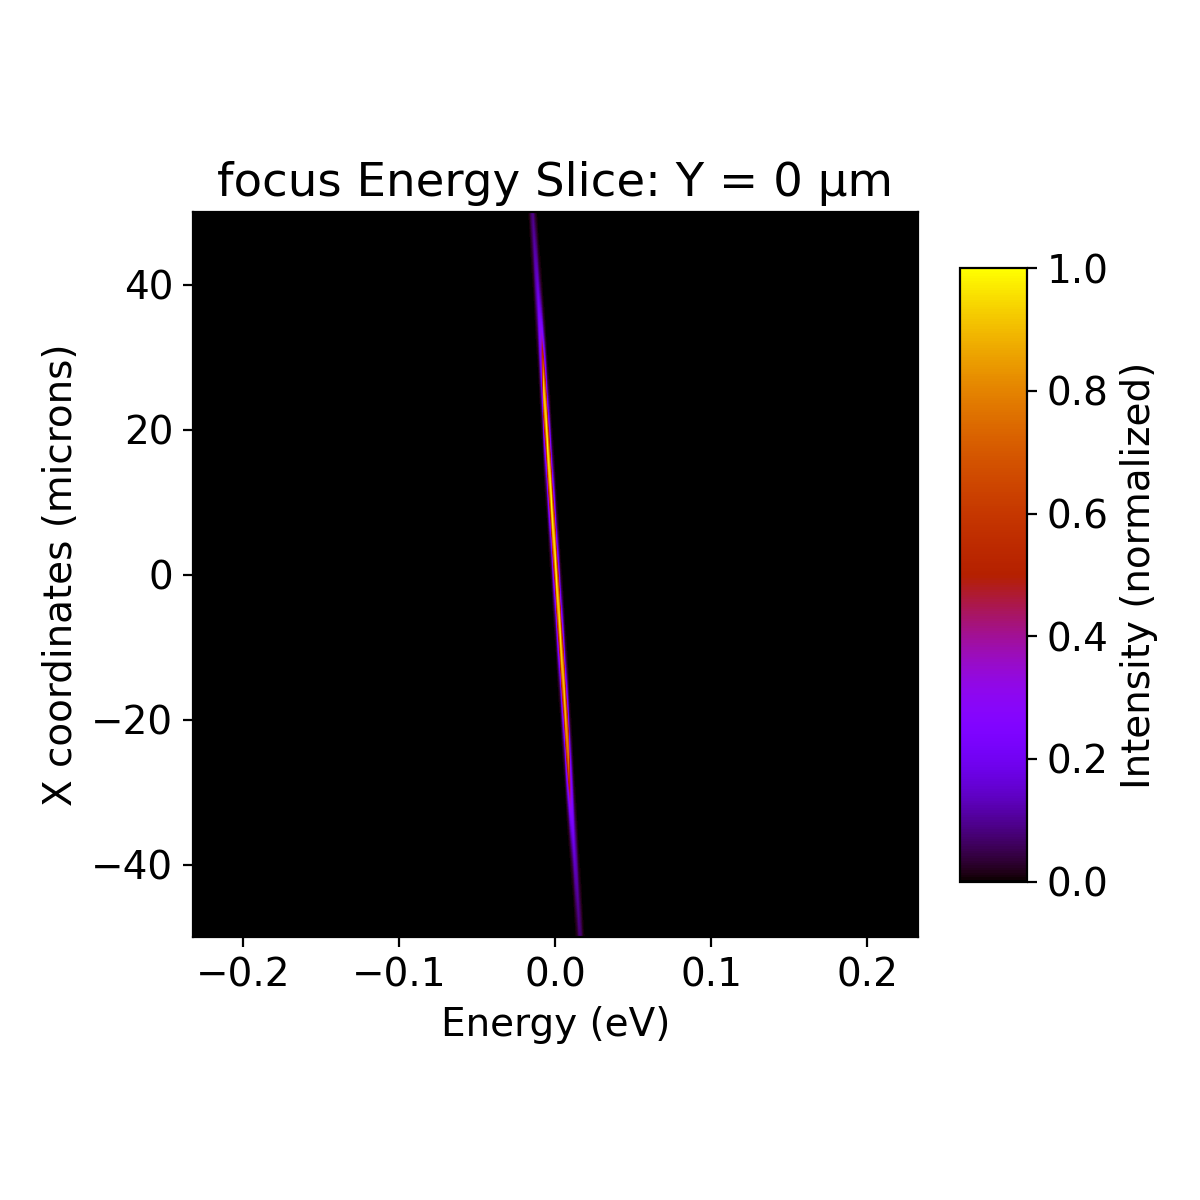

<IPython.core.display.Javascript object>


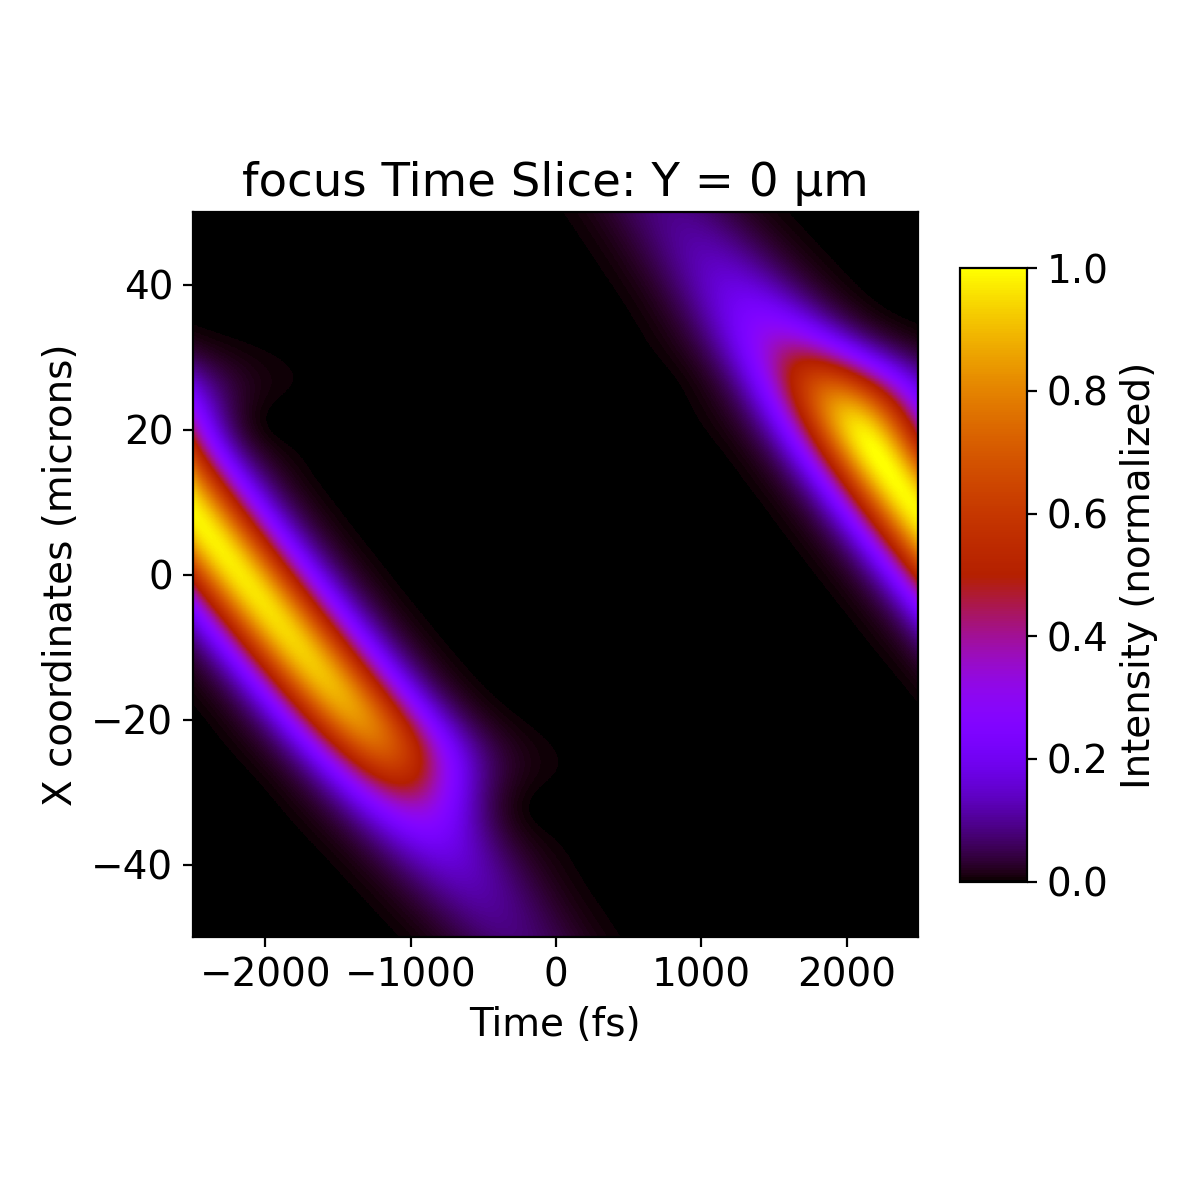

<IPython.core.display.Javascript object>


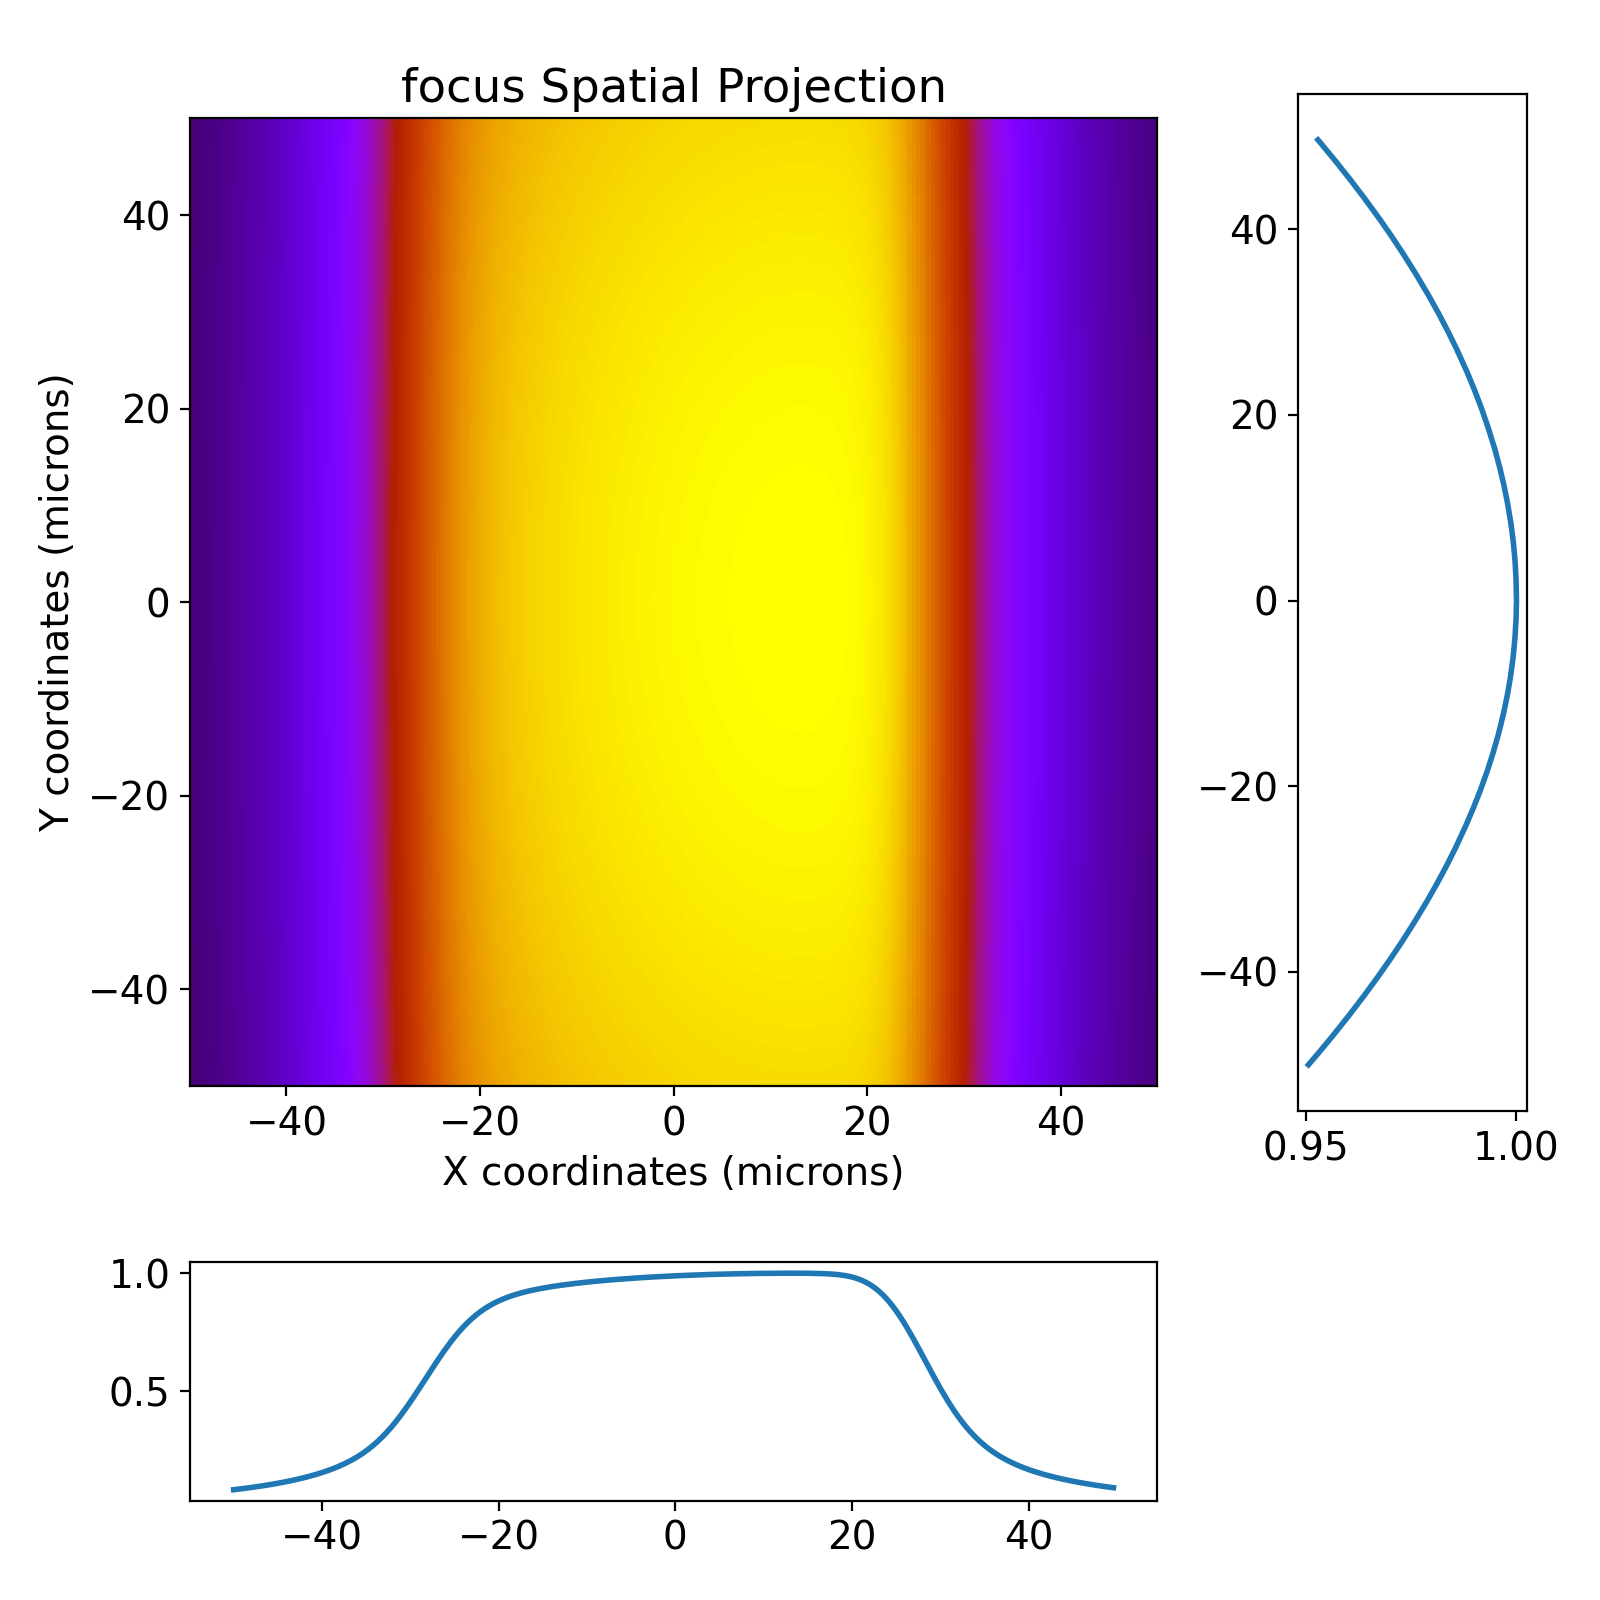

(<matplotlib.axes._subplots.AxesSubplot at 0x120fe3240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x121010588>)

In [9]:
# plot energy slice of focus
pulse.imshow_energy_slice('focus')
# plt.savefig(fig_path+'option1_focus_energy.png')
# plot time slice of focus
pulse.imshow_time_slice('focus', shift=-1000)
# plt.savefig(fig_path+'option1_focus_time.png')
# show spatial projection
pulse.imshow_projection('focus')
# plt.savefig(fig_path+'option1_focus_spatial.png')

### Visualize output

<IPython.core.display.Javascript object>


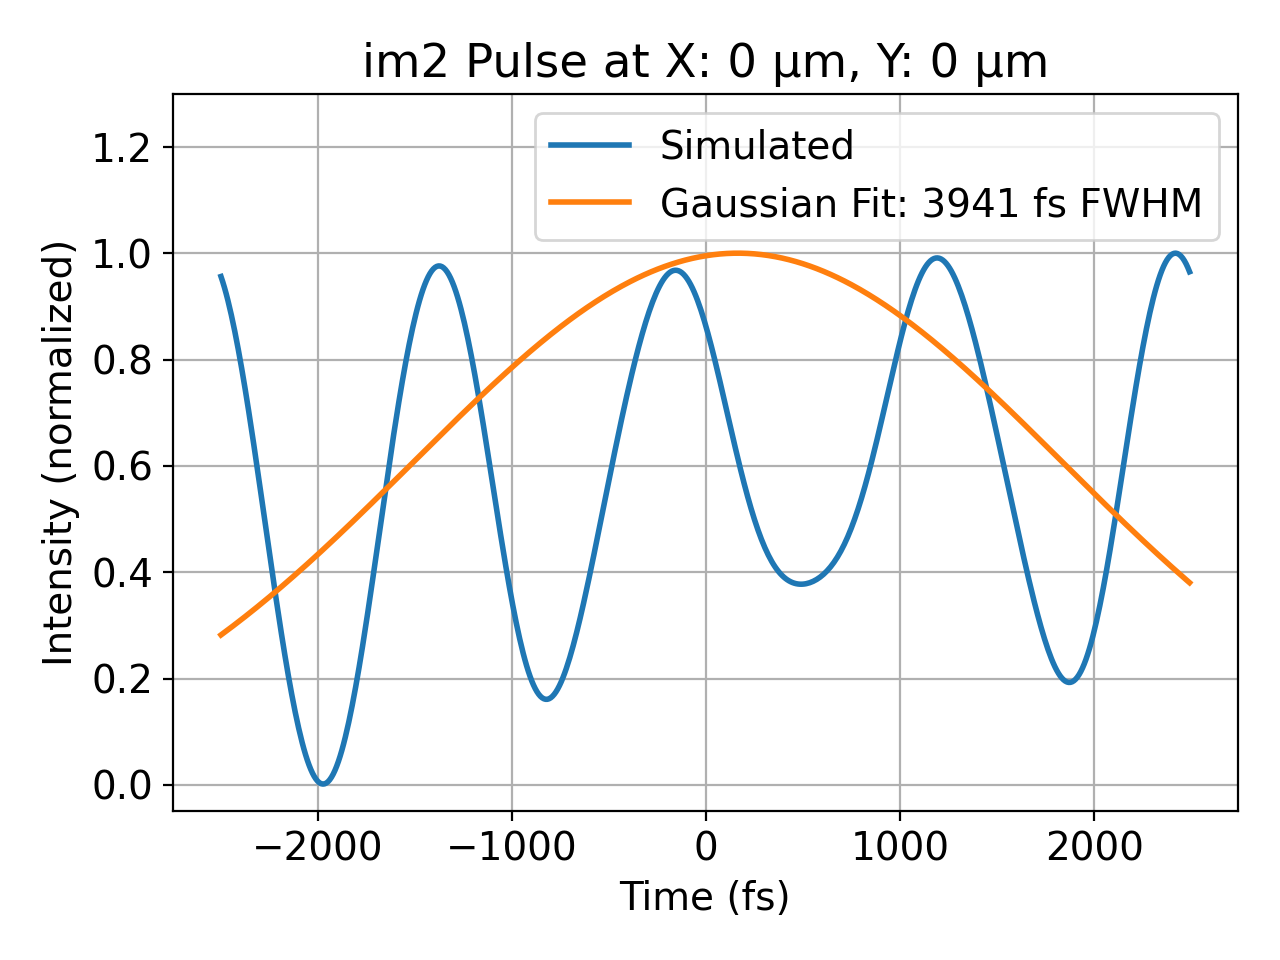

<IPython.core.display.Javascript object>


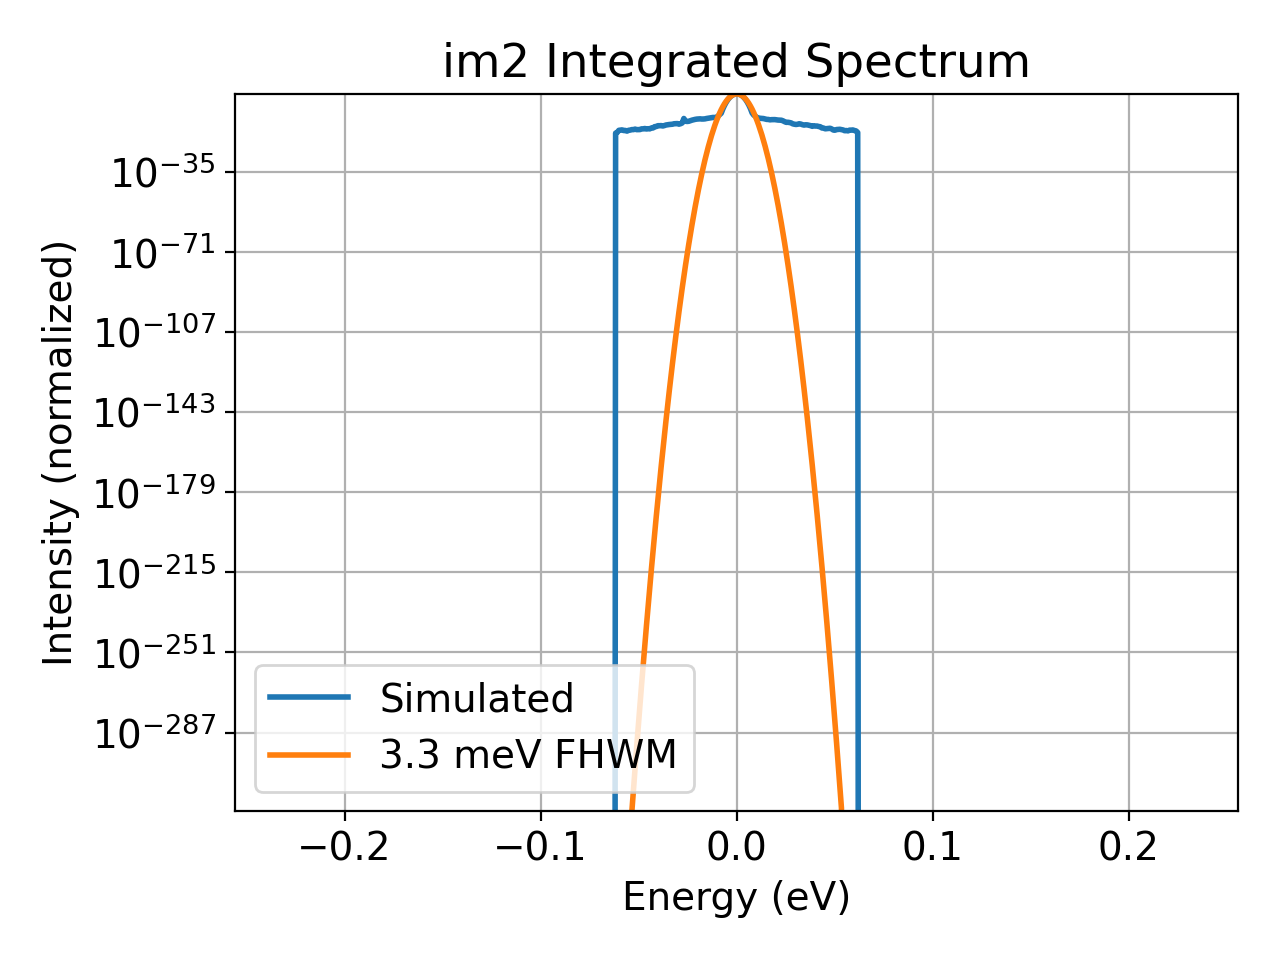

/Users/seaberg/Python/lcls_beamline_toolbox/lcls_beamline_toolbox/xraybeamline2d/beam1d.py:1464: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-.05,1.3)


<IPython.core.display.Javascript object>


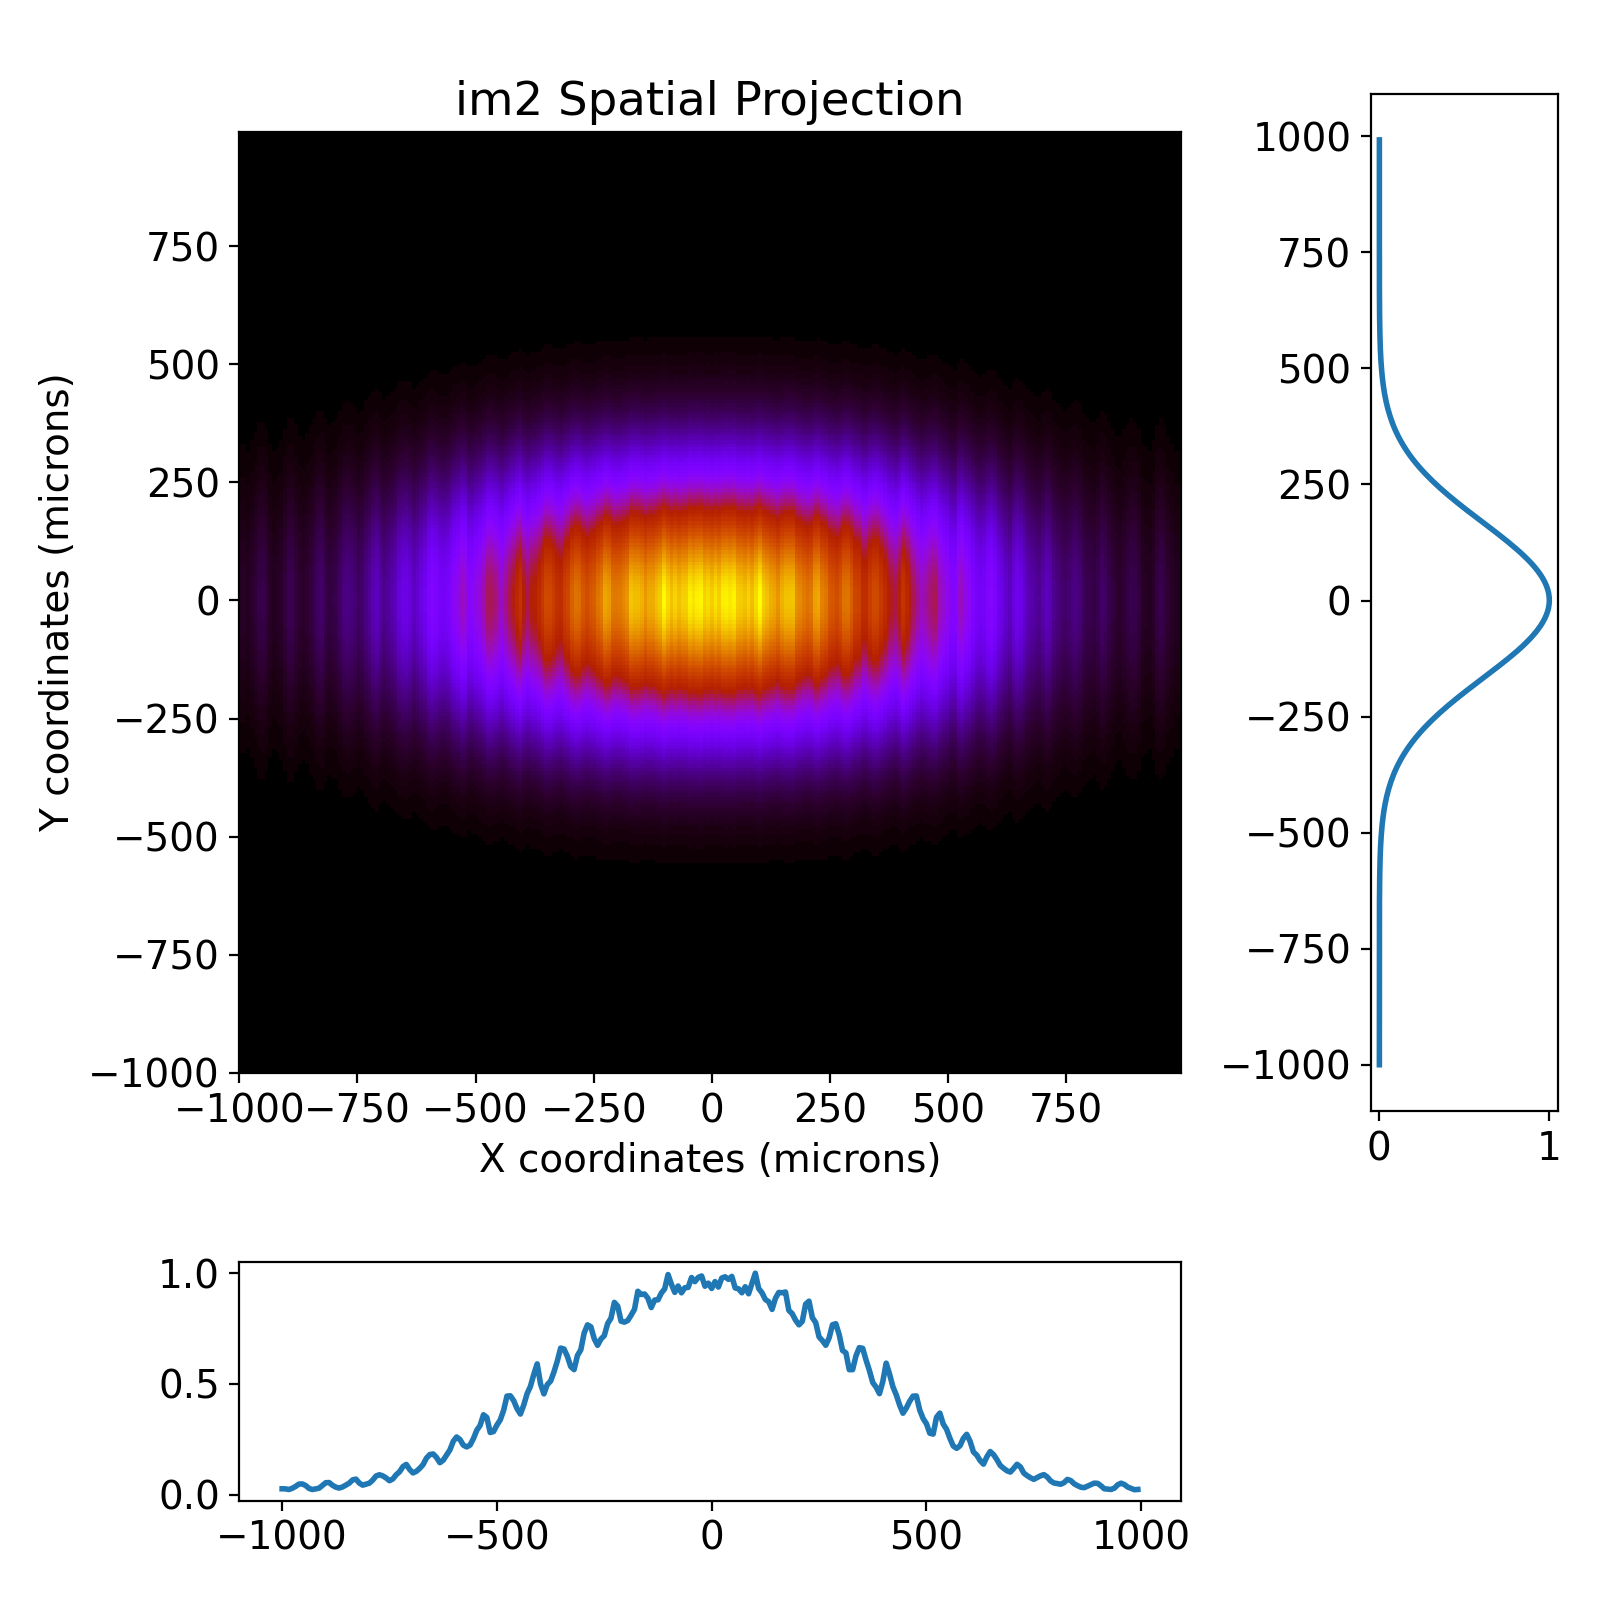

<IPython.core.display.Javascript object>


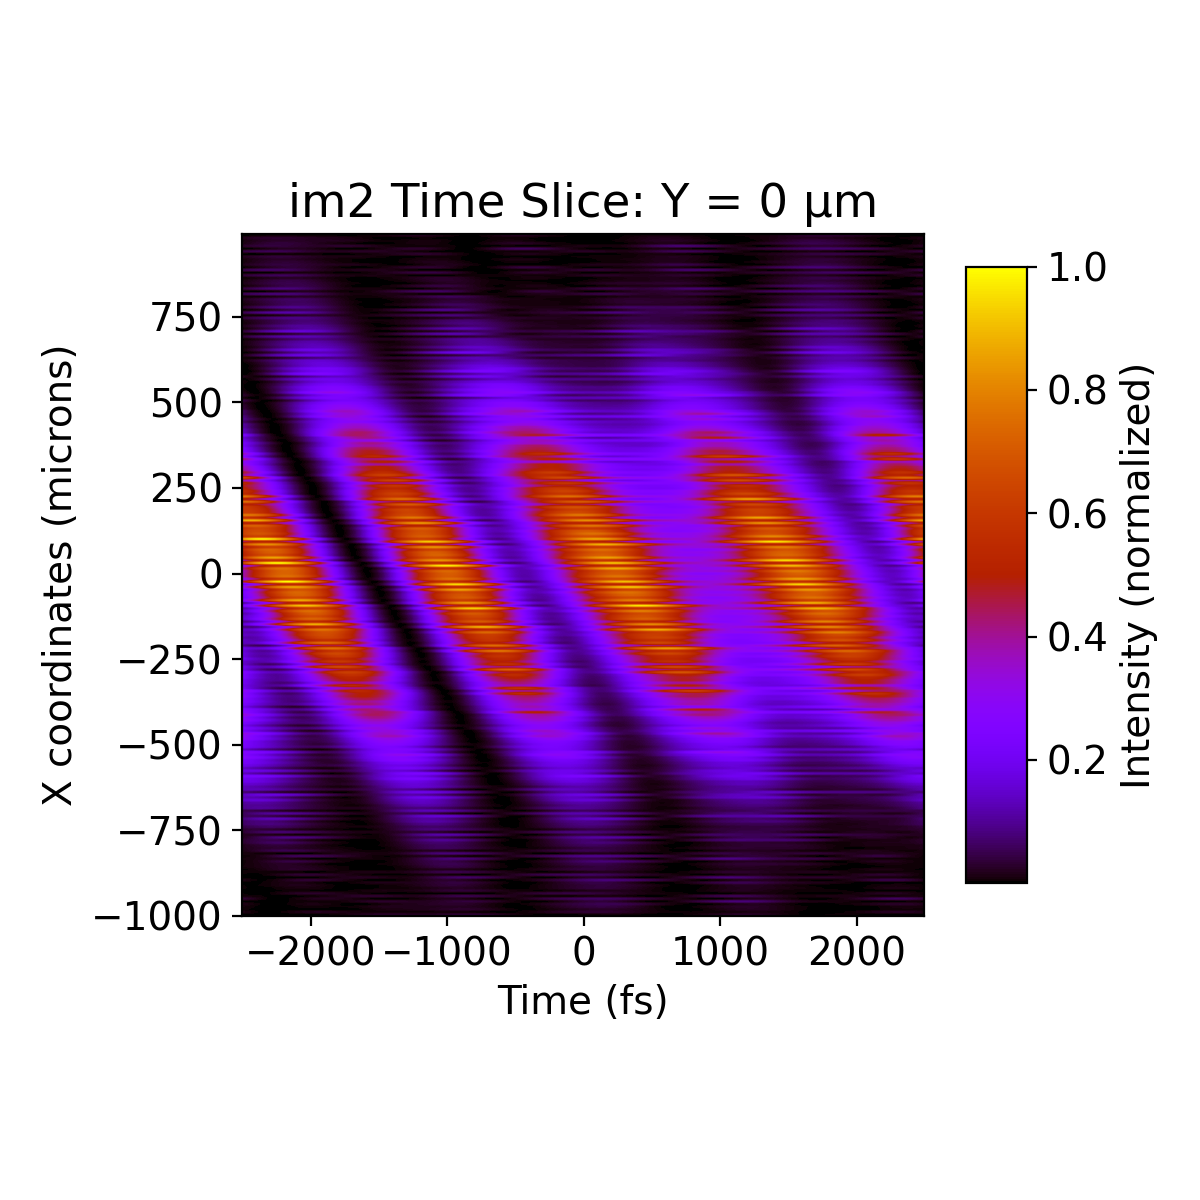

<IPython.core.display.Javascript object>


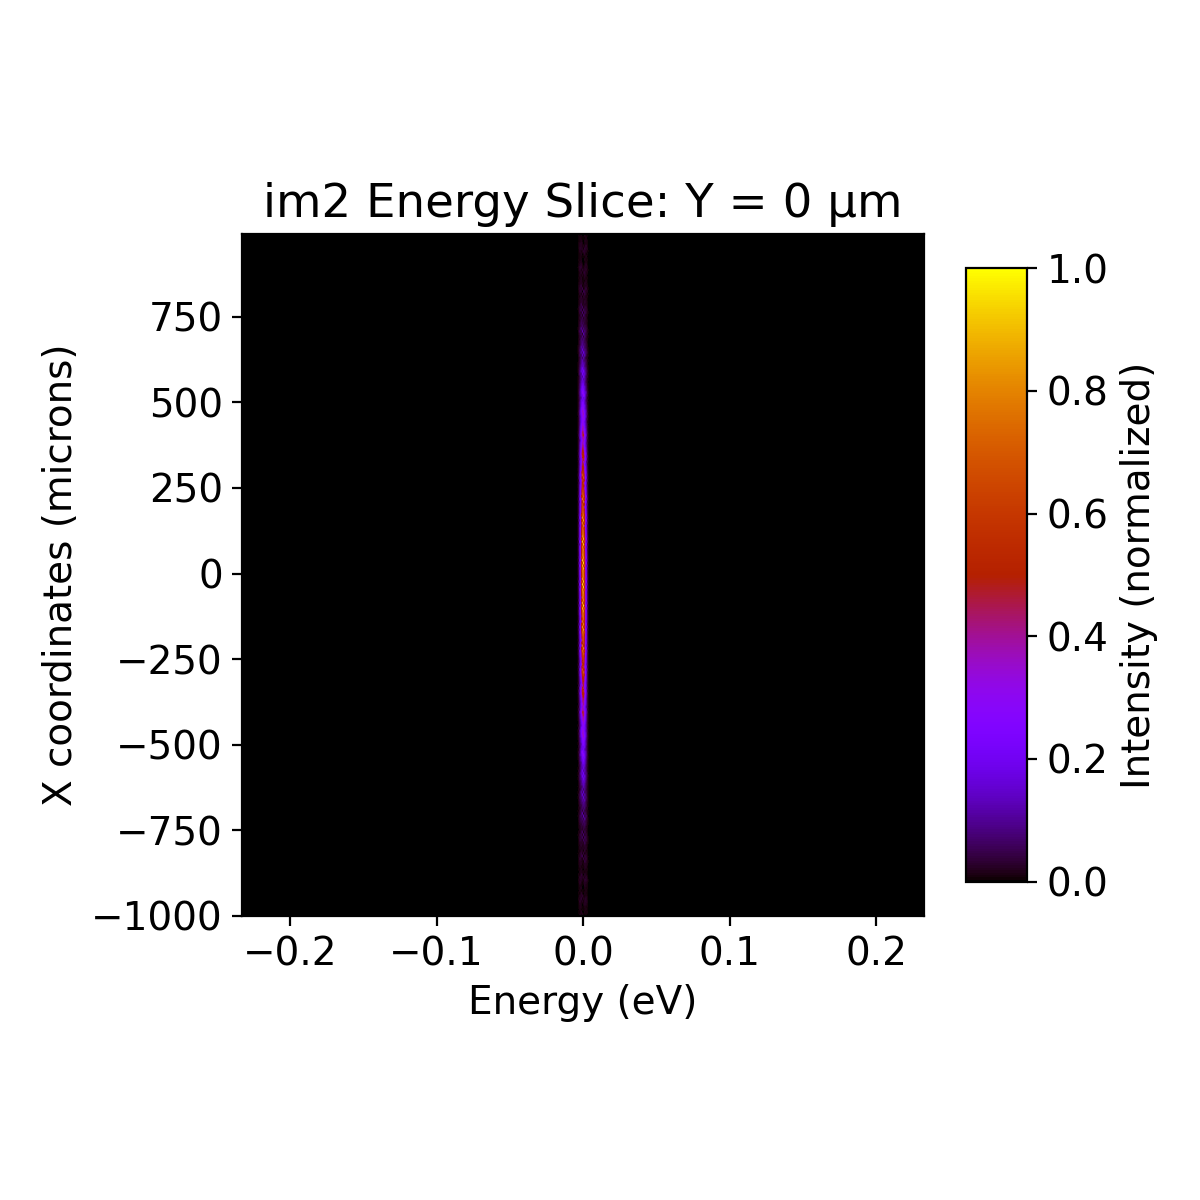

<IPython.core.display.Javascript object>


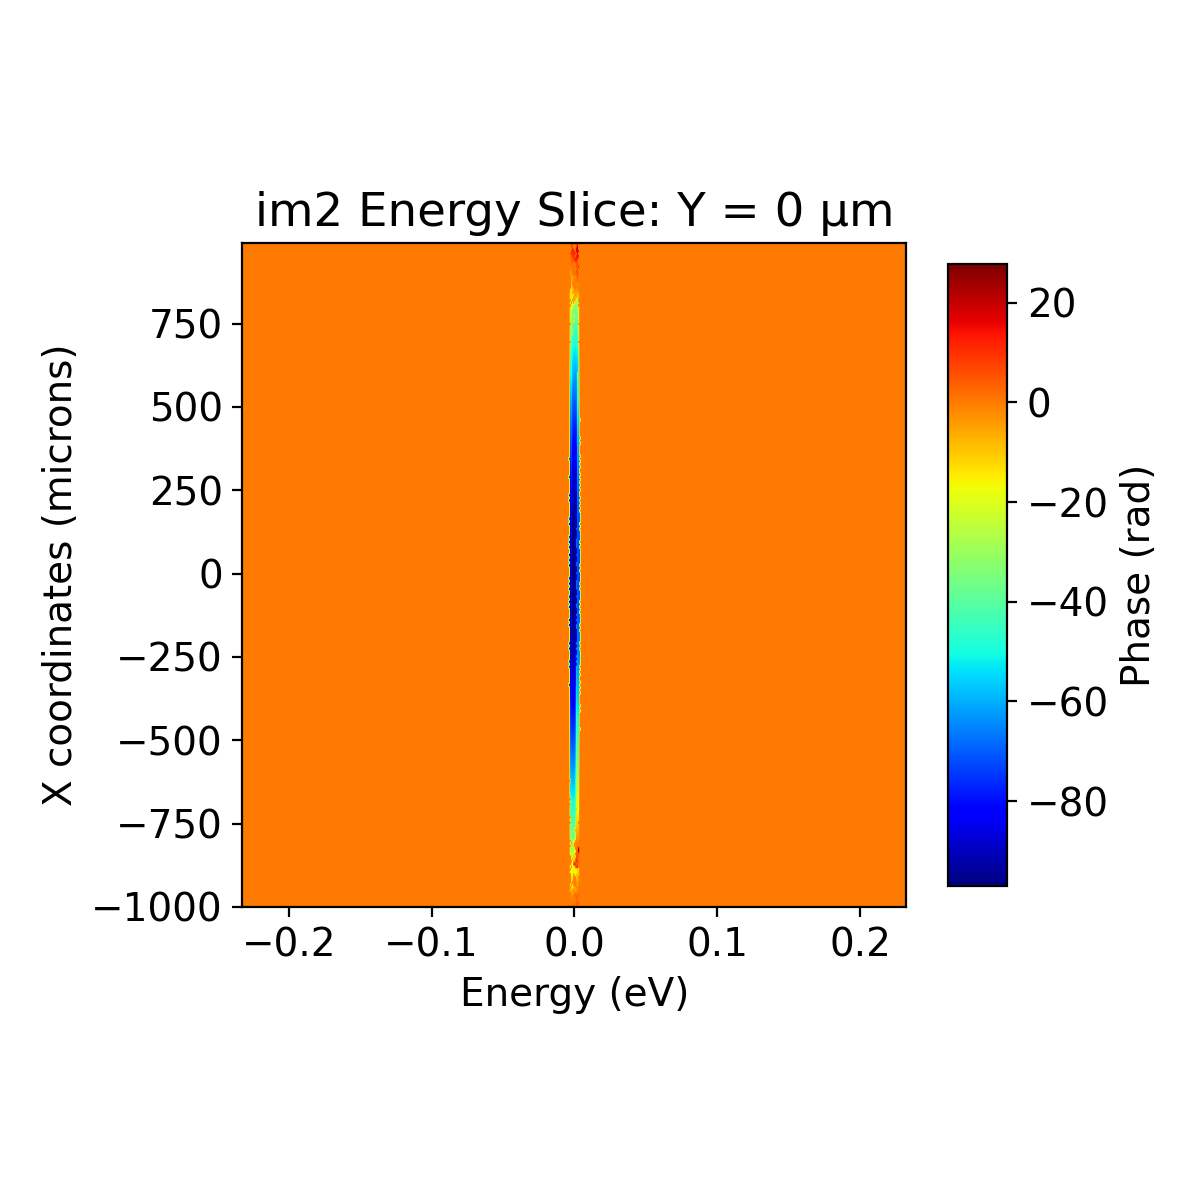

0.6864509408097511
0.003085172239756283
0.022300104086049377
17795.000061894993
0.027536539439560845


In [10]:
# plot output pulse at beam center
pulse.plot_pulse('im2', shift=0)
# plt.savefig(fig_path+'option1_output_pulse.png')
# plot output spectraum at beam center
pulse.plot_spectrum('im2', integrated=True, log=True)
# plt.savefig(fig_path+'option1_output_spectrum.png')
# show spatial projection of output
pulse.imshow_projection('im2')
# plt.savefig(fig_path+'option1_output_spatial.png')
# show time slice of output
pulse.imshow_time_slice('im2', shift=400)
# plt.savefig(fig_path+'option1_output_time.png')
# show energy slice of output
pulse.imshow_energy_slice('im2')
# plt.savefig(fig_path+'option1_output_energy.png')
# show spectral phase slice of output
pulse.imshow_energy_slice('im2', image_type='phase')

print(pulse.pulsefront_tilt('im2'))
print(pulse.pulse_bandwidth('im2'))
print(pulse.throughput('im0','im2'))
print(pulse.central_energy('im2'))

print(pulse.pulse_bandwidth('im2')/pulse.pulse_bandwidth('im0')*.95**4)

### Visualize input

<IPython.core.display.Javascript object>


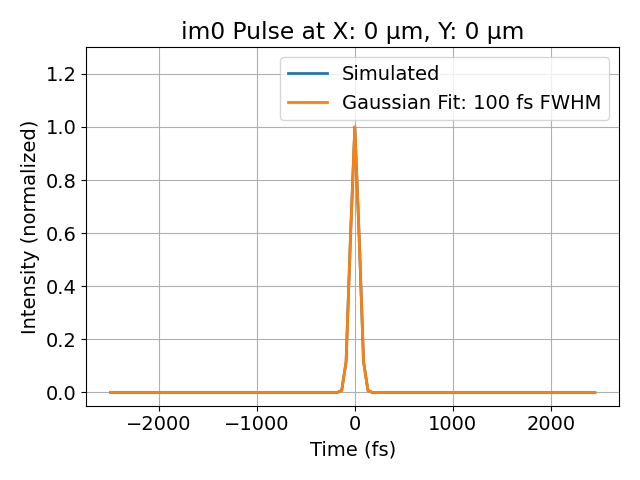

<IPython.core.display.Javascript object>


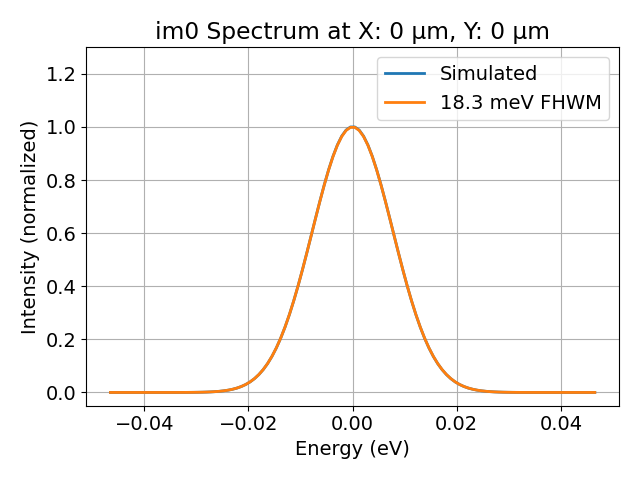

<IPython.core.display.Javascript object>


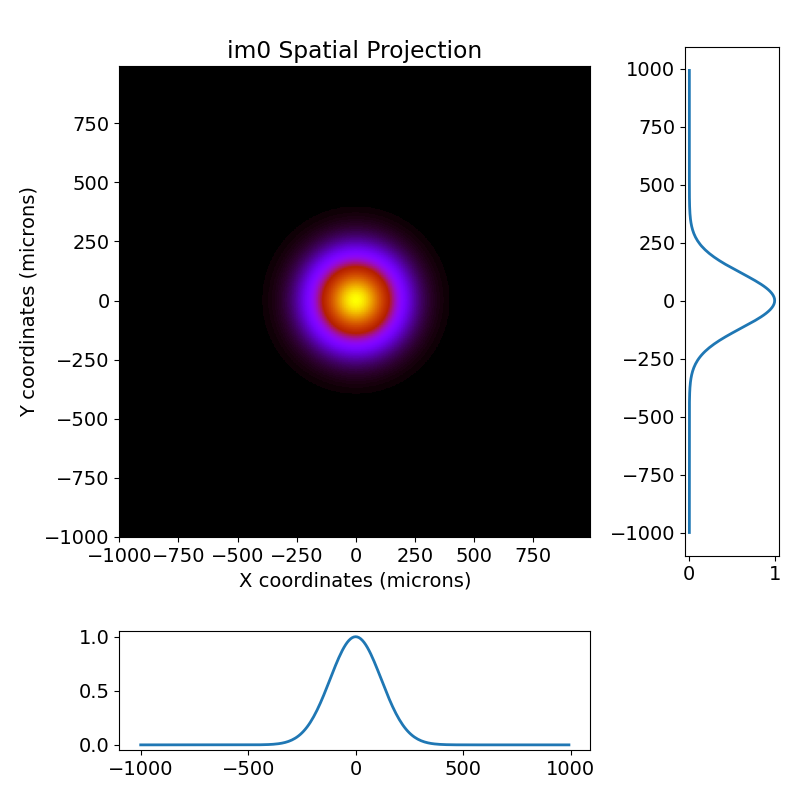

(<matplotlib.axes._subplots.AxesSubplot at 0x128d84b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128dc2320>)

In [80]:
fig_path = '/Users/Matt/OneDrive - SLAC National Accelerator Laboratory/Projects/Tunable Mono/figures/'

# plot input pulse at beam center
pulse.plot_pulse('im0')
# plt.savefig(fig_path+'input_pulse_no_slit.png')
# plot input spectrum at beam center
pulse.plot_spectrum('im0')
# plt.savefig(fig_path+'input_spectrum_no_slit.png')
# plot input beam spatial projection
pulse.imshow_projection('im0')
# plt.savefig(fig_path+'input_spatial_no_slit.png')

### Visualize focus properties

<IPython.core.display.Javascript object>


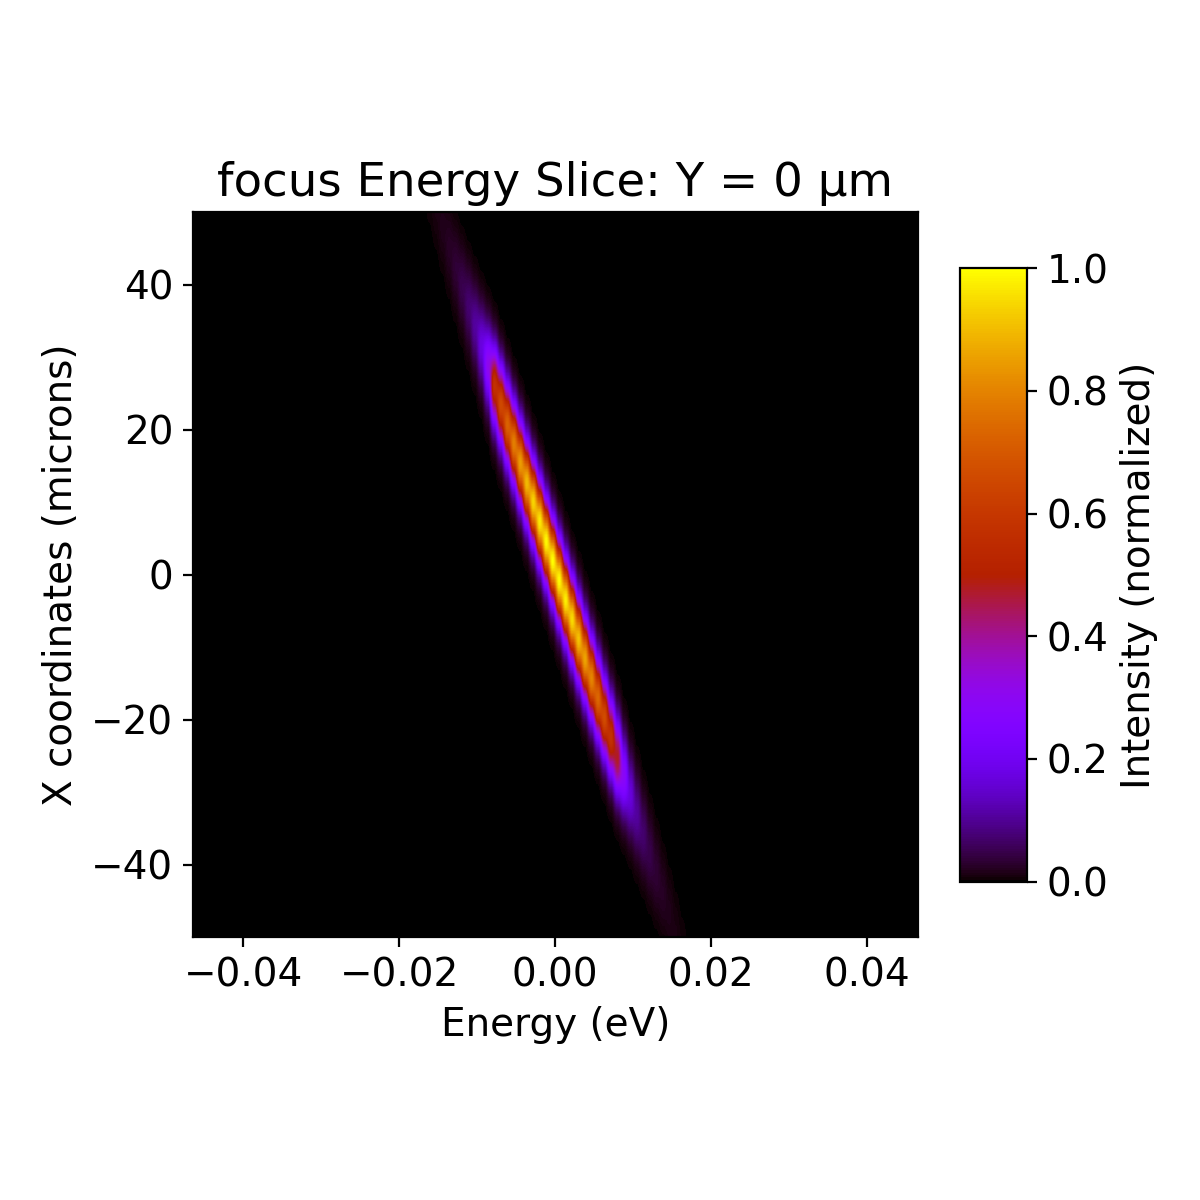

/Users/seaberg/Python/lcls_beamline_toolbox/lcls_beamline_toolbox/xraybeamline2d/beam1d.py:1281: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6, 6))


<IPython.core.display.Javascript object>


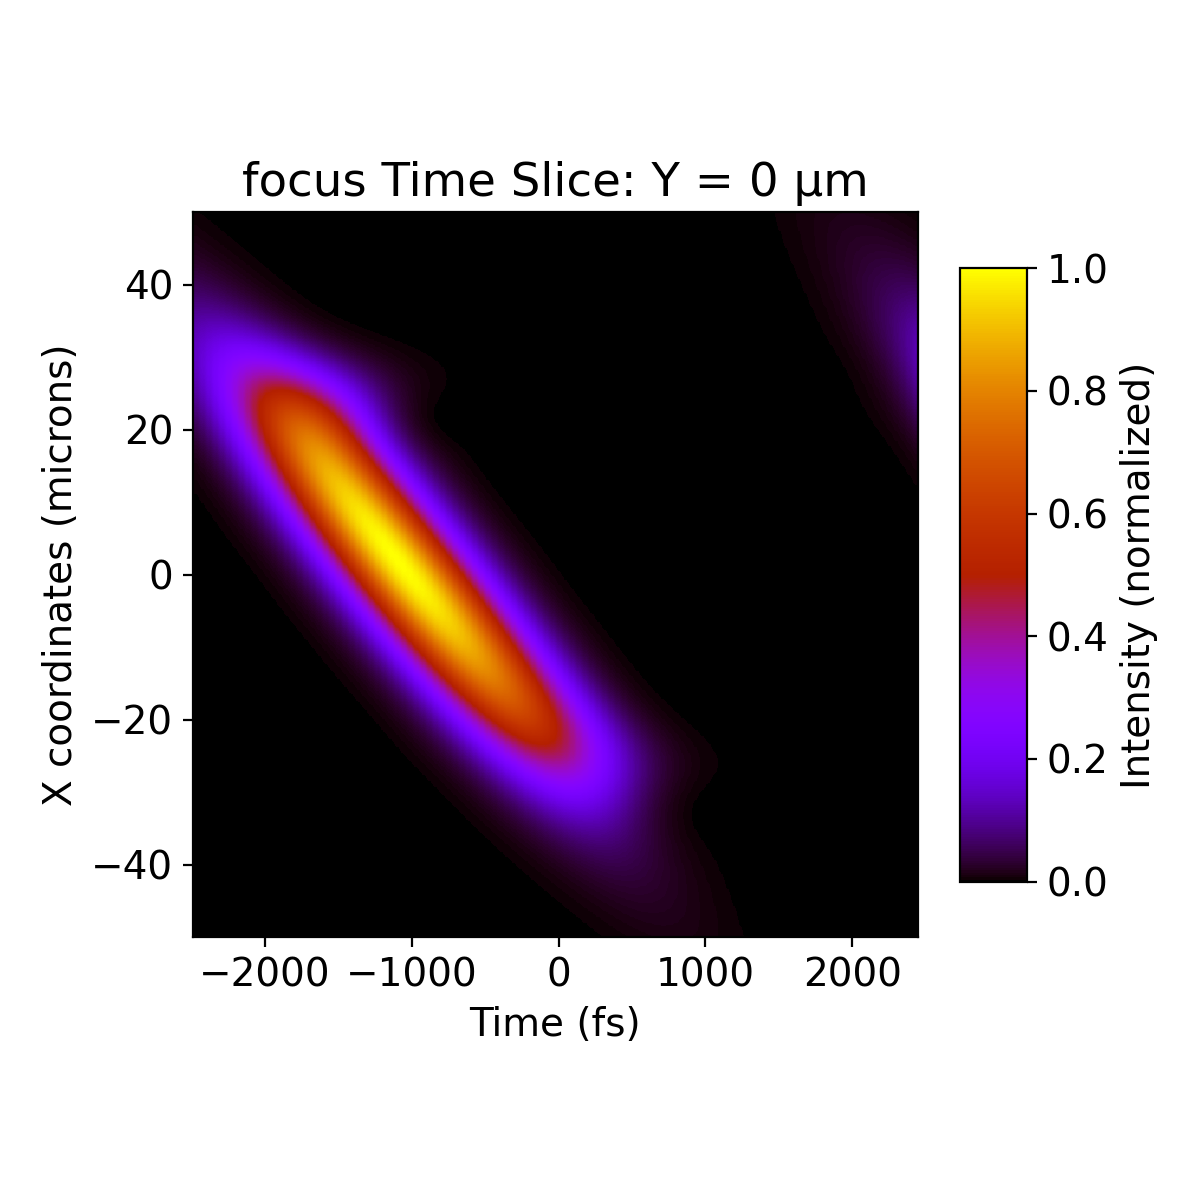

/Users/seaberg/Python/lcls_beamline_toolbox/lcls_beamline_toolbox/xraybeamline2d/beam1d.py:1135: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 8))


<IPython.core.display.Javascript object>


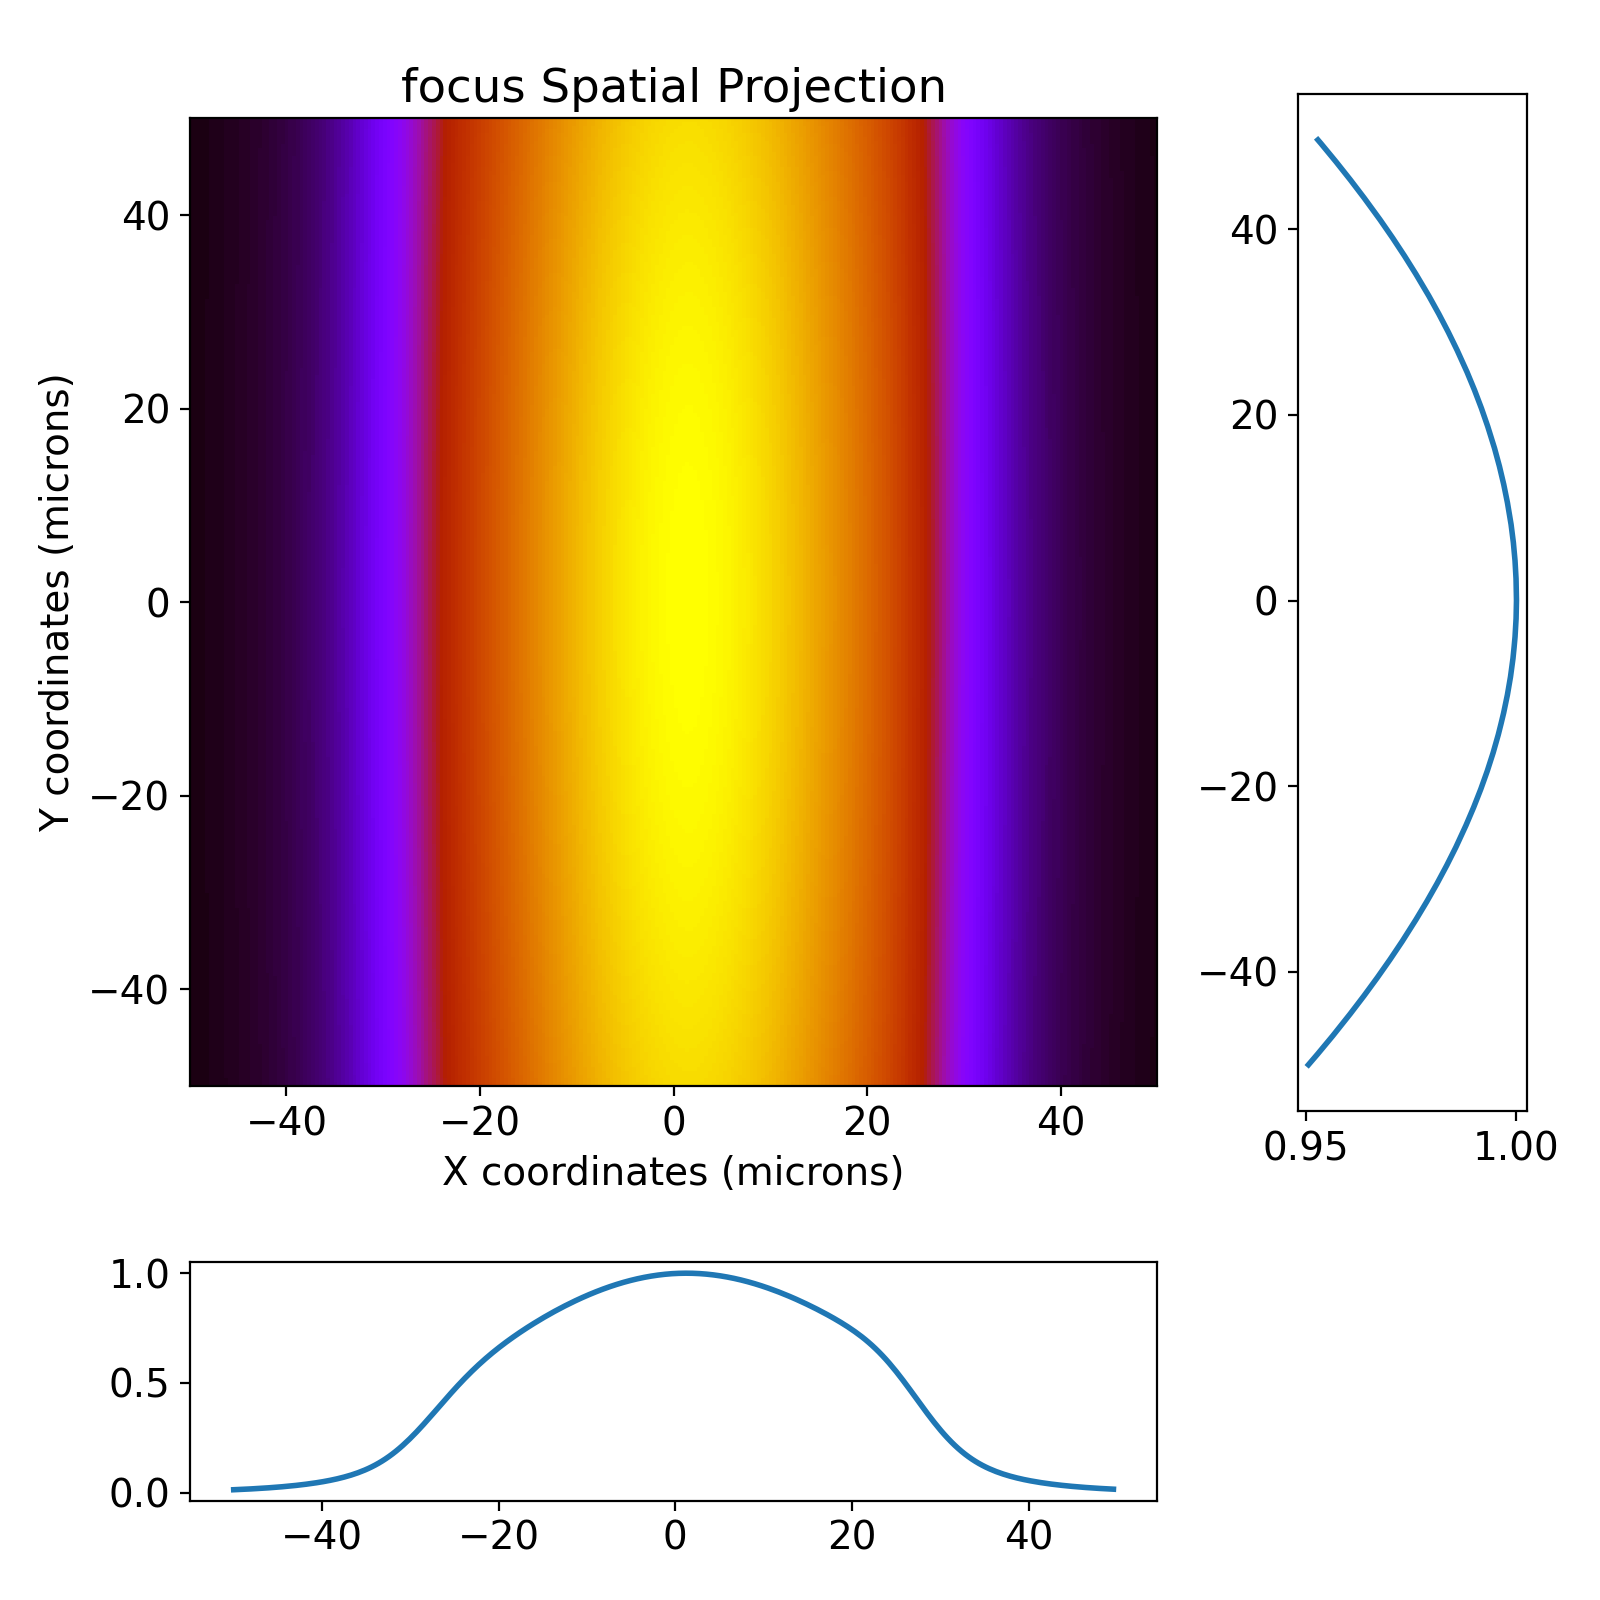

(<matplotlib.axes._subplots.AxesSubplot at 0x12213d048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12216c5c0>)

In [22]:
# plot energy slice of focus
pulse.imshow_energy_slice('focus')
# plt.savefig(fig_path+'option1_focus_energy_no_slit.png')
# plot time slice of focus
pulse.imshow_time_slice('focus', shift=-1000)
# plt.savefig(fig_path+'option1_focus_time_no_slit.png')
# show spatial projection
pulse.imshow_projection('focus')
# plt.savefig(fig_path+'option1_focus_spatial_no_slit.png')

In [152]:
def define_devices(f1, f2):
    # crystal asymmetry angle
    alphaAsym = 27.98*np.pi/180

    # distance between crystal 2 and 1st CRL, 2nd CRL and crystal 4 
#     f1 = 9.822
#     # distance between CRLs and focus
#     f2 = 10

    # crystal reflection hkl index
    hkl = [6,6,0]

    # initialize the beam
    b1 = beam.Beam(beam_params=beam_params)

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=2e-3, N=256)
    crl0 = optics.CRL('crl0', z=930, roc=660e-6, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=931, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2,pol='s', delta=0e-6)
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im_upstream = optics.PPM('im_upstream', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

    # CRL with ~1 meter focal length (modeled as single element for now)
    crl1 = optics.CRL('crl1', z=crystal2.z+f1, roc=21e-6, diameter=5e-3)

    # viewing point downstream of first crl
    im1 = optics.PPM('im1', z=crl1.z+.1,N=256,FOV=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1.z+f2, FOV=100e-6, N=256)

    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2 + 1e-3, x_width=8e-6, y_width=2e-3)

    # second CRL with ~1 meter focal length, for collimation
    crl2 = optics.CRL('crl2', z=crl1.z+2*f2, roc=21e-6, diameter=5e-3)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+2, E0=E0,alphaAsym=0, orientation=2,
                             asym_type='emergence',pol='s')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+2 + (f1-2)*np.cos(crystal1.beta0*2), E0=E0,alphaAsym=-alphaAsym, 
                              asym_type='emergence', orientation=0,pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=2e-3, N=256)

    # list of devices to propagate through
    devices = [crl0,im0,crystal1,crystal2,im_upstream, im1, crl1, focus, crl2, crystal3, crystal4, im2]
    # devices = [im0,crystal1,crystal2,im_upstream, im1, crl1, focus, crl2, crystal3, crystal4, im2]
    
    return devices

In [153]:
%%capture capt
f1 = np.linspace(9.822-.1, 9.822+.1, 50)

duration = np.zeros(50)

for i, f in enumerate(f1):
    
    devices = define_devices(f, 10)
    # initialize beamline
    mono_beamline = beamline.Beamline(devices)
    # reset central photon energy
    beam_params['photonEnergy'] = 17795

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=4000)

    print('Number of spectral components: {:d}'.format(pulse.N))
    pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
    centroid, duration[i] = pulse.pulse_duration('im2')

<IPython.core.display.Javascript object>


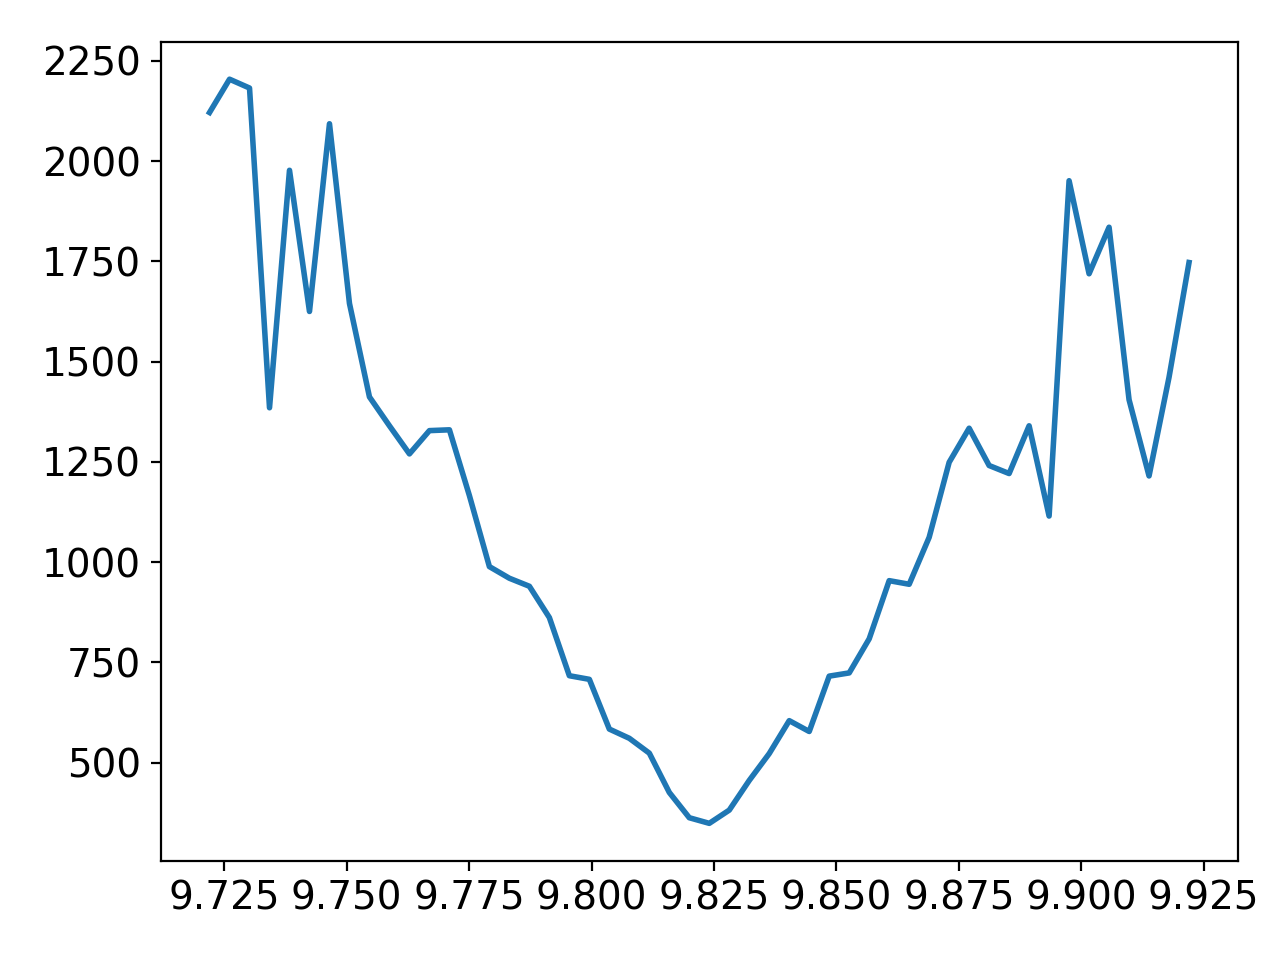

In [154]:
plt.figure()
plt.plot(f1, duration)

In [2]:
lambda0 = 1239.8/9000*1e-9
phase = 80
path = phase*lambda0/2/np.pi

In [3]:
print(path)

1.7539582084029499e-09


In [8]:
1/(1/6+1/3)

2.0

In [34]:
37/20

1.85

In [11]:
400/8

50.0

In [32]:
9*2/20

0.9

In [45]:
np.pi*(10e-6)**2/b1.lambda0

4.509166097001966

In [47]:
1.18385e-5*18**(-.829988)

1.0750670778663879e-06

In [50]:
x = 18
y = -3.6959e-6*x**6 + 2.787e-4*x**5 - 7.8487e-3*x**4 + 1.088e-1*x**3 - 1.057*x**2 + 9.881*x - 73.1

In [51]:
print(y)

-26.196708281599996
